In [1]:
# Importing the libraries 
import numpy as np
import pandas as pd

In [2]:
# looding the seer data set and giving names to the columns because no column name in the text file

col_names = ["Age", "Tumor Stage", "CS Tumor Size", "Tumor Size Summary",
    "Radiation", "Chemotherapy", "Surgery", "Vital Status", "Survival Months"]

seer = pd.read_csv("Lung Cancer.txt", sep="\t", header=None, names=col_names)

In [3]:
# calling the first five rows in the seer data set
seer.head(5)

,Age,Tumor Stage,CS Tumor Size,Tumor Size Summary,Radiation,Chemotherapy,Surgery,Vital Status,Survival Months
0,65-69 years,Blank(s),Blank(s),070,None/Unknown,Yes,33,Alive,0059
1,75-79 years,Distant,030,Blank(s),None/Unknown,No/Unknown,0,Dead,0003
2,65-69 years,Localized,030,Blank(s),None/Unknown,No/Unknown,0,Dead,0029
3,65-69 years,Blank(s),Blank(s),109,Beam radiation,Yes,0,Dead,0027
4,65-69 years,Unstaged,999,Blank(s),None/Unknown,No/Unknown,0,Dead,0000


In [4]:
# The Age is inform of a range which will need to be converted to a midpoint value for the purpose of modelling

def midpoint(age_range):
    if isinstance(age_range, str):
        age_range = age_range.strip()
        if '90+' in age_range:
            return 95
        elif '-' in age_range:
            start, end = age_range.replace(" years", "").split('-')
            return (int(start) + int(end)) // 2
    return None  # this was to handle the missing value

seer["Age at Diagnosis"] = seer["Age"].apply(midpoint).astype("Int64")

In [5]:
# %% [markdown]
# %%
print("""
The CS Tumor Size and Tumor Size Summary need to be combined into one. This has to be combined because the cases before 2016
uses CS Tumor Size, and the cases after 2016+ use Tumor Size Summary.
""")

seer["Tumor Size Summary"] = seer["Tumor Size Summary"].replace("Blank(s)", pd.NA)
seer["CS Tumor Size"] = seer["CS Tumor Size"].replace("Blank(s)", pd.NA)
seer["Tumor Size"] = seer["Tumor Size Summary"].combine_first(seer["CS Tumor Size"])
seer["Tumor Size"] = pd.to_numeric(seer["Tumor Size"], errors="coerce")


The CS Tumor Size and Tumor Size Summary need to be combined into one. This has to be combined because the cases before 2016
uses CS Tumor Size, and the cases after 2016+ use Tumor Size Summary.



In [6]:
# Radiaton, Chemotherapy, and Surgery will need to be put under a column called Treatment Type, where one value will be assigned to one patient

def simplify_treatment(row): # this takes a single row from a dataframe
    chemo = str(row["Chemotherapy"]).strip().lower() == "yes"
    radio = str(row["Radiation"]).strip().lower() != "none/unknown"
    surgery = str(row["Surgery"]).strip() not in ["00", "0", "None", "NA"]

    if chemo:
        return "Chemotherapy"
    elif radio:
        return "Radiation"
    elif surgery:
        return "Surgery"
    else:
        return "None"

seer["Treatment Type"] = seer.apply(simplify_treatment, axis=1)

In [7]:
# selecting the final columns and assigning it to seer_data

seer_data = seer[["Age at Diagnosis", "Tumor Stage", "Tumor Size", "Treatment Type", "Vital Status", "Survival Months"]]

In [8]:
seer_data.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Months
0,67,Blank(s),70,Chemotherapy,Alive,0059
1,77,Distant,30,None,Dead,0003
2,67,Localized,30,None,Dead,0029
3,67,Blank(s),109,Chemotherapy,Dead,0027
4,67,Unstaged,999,None,Dead,0000


In [9]:
# count the number of occurrences of each unique value in Tumor Size column
seer_data['Tumor Size'].value_counts()

Tumor Size
999    132206
20      16484
30      15575
15      15373
25      15271
        ...  
720         1
267         1
276         1
375         1
896         1
Name: count, Length: 351, dtype: int64

In [10]:
# %% [markdown]
# %%
print("""
According to SEER Documentation regarding tumor size: https://seer.cancer.gov/tumorsize/
The 999 and 990 as tumor size will be changed to NAN. Any tumor size that is above 401 is considered to be unreasonable and will also be changed to 
NAN """)

seer_data = seer_data.copy() # making a copy of the data
seer_data["Tumor Size"] = pd.to_numeric(seer_data["Tumor Size"], errors='coerce')
seer_data["Tumor Size"] = seer_data["Tumor Size"].replace([990, 999], np.nan)
seer_data["Tumor Size"] = seer_data["Tumor Size"].apply(lambda x: x if x < 401 else np.nan)
seer_data["Tumor Size"] = seer_data["Tumor Size"].astype("Int64")


According to SEER Documentation regarding tumor size: https://seer.cancer.gov/tumorsize/
The 999 and 990 as tumor size will be changed to NAN. Any tumor size that is above 401 is considered to be unreasonable and will also be changed to 
NAN 


In [11]:
# count the number of occurrences of each unique value in Tumor Size column
seer_data['Tumor Size'].value_counts()

Tumor Size
20     16484
30     15575
15     15373
25     15271
40     13069
       ...  
245        1
202        1
201        1
276        1
375        1
Name: count, Length: 258, dtype: Int64

In [12]:
# converting the survival months to days (multiplying each row by 30.44) and renaming it as survival days

seer_data["Survival Months"] = pd.to_numeric(seer_data["Survival Months"], errors='coerce') # converting to numeric
seer_data["Survival Days"] = (seer_data["Survival Months"] * 30.44).round().astype("Int64")

# dropping the column Survival Months
seer_data.drop(columns=["Survival Months"], inplace=True)

In [13]:
seer_data.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Days
0,67,Blank(s),70,Chemotherapy,Alive,1796
1,77,Distant,30,None,Dead,91
2,67,Localized,30,None,Dead,883
3,67,Blank(s),109,Chemotherapy,Dead,822
4,67,Unstaged,<NA>,None,Dead,0


In [14]:
seer_data.shape

# We have 633,039 rows and 6 columns

(633039, 6)

In [15]:
# checking the number of missing values for each column
seer_data.isnull().sum()

Age at Diagnosis        21
Tumor Stage              0
Tumor Size          134774
Treatment Type           0
Vital Status             0
Survival Days        14780
dtype: int64

In [16]:
# The non-values in Age at Diagnosis will be dropped. Dropping the missing values will only be a minimal loss in the daataset
seer_data = seer_data.dropna(subset=['Age at Diagnosis'])

In [17]:
seer_data.isnull().sum()

Age at Diagnosis         0
Tumor Stage              0
Tumor Size          134766
Treatment Type           0
Vital Status             0
Survival Days        14780
dtype: int64

In [18]:
# The missing values in the survival days will be dropped, but we will need to check the missing values of the Survival Days using the Vital Status 
# to determine whether it referred to Dead or Alive.
missing_survival_dead_seer = seer_data[(seer_data["Vital Status"] == "Dead") &(seer_data["Survival Days"].isna())]

missing_survival_dead_seer

# The result below shows that all the missing values in the survival days are all dead.

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Days
106,95,Localized,<NA>,None,Dead,<NA>
210,57,Distant,<NA>,None,Dead,<NA>
257,87,Blank(s),<NA>,Surgery,Dead,<NA>
304,82,Unstaged,<NA>,Surgery,Dead,<NA>
312,77,Unstaged,<NA>,Surgery,Dead,<NA>
...,...,...,...,...,...,...
633011,52,Blank(s),<NA>,Surgery,Dead,<NA>
633012,72,Blank(s),<NA>,Surgery,Dead,<NA>
633013,67,Blank(s),<NA>,Surgery,Dead,<NA>
633014,72,Blank(s),<NA>,Surgery,Dead,<NA>


In [19]:
# removing rows where the vital status is Dead and the Survival Days is missing.
seer_data = seer_data[~((seer_data["Vital Status"] == "Dead") & (seer_data["Survival Days"].isna()))]

In [20]:
seer_data.isnull().sum()

Age at Diagnosis         0
Tumor Stage              0
Tumor Size          120286
Treatment Type           0
Vital Status             0
Survival Days            0
dtype: int64

In [21]:
# We also need to check the survival day that is equal to 0. This also needs to be dropped because it indicates that there was no follow-up on such
# patient as at the time it was recorded, and it will not be required in our modelling because if there are too many zeros(0), the model might overfit to
# early death cases. 

zero_survival_seer = seer_data[seer_data["Survival Days"] == 0]

zero_survival_seer

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Days
4,67,Unstaged,<NA>,None,Dead,0
9,62,Blank(s),<NA>,None,Dead,0
12,87,Blank(s),<NA>,None,Dead,0
21,77,Distant,<NA>,None,Dead,0
32,72,Distant,150,None,Dead,0
...,...,...,...,...,...,...
633023,67,Blank(s),<NA>,None,Dead,0
633024,77,Blank(s),<NA>,None,Dead,0
633026,67,Blank(s),<NA>,None,Dead,0
633032,72,Blank(s),<NA>,None,Dead,0


In [22]:
# drooping rows with survival days equal to 0

seer_data = seer_data[seer_data["Survival Days"] != 0]

In [23]:
# confirming if the survival days equal to 0 as been dropped from the data

print((seer_data["Survival Days"] == 0).sum())

0


In [24]:
# the Blank(s) and Unstage in the tumor stage column will not be dropped but will be replaced with 'Unknown', this will enable the machine to learn 
# patterns from patients where the tumor stage is unknown.

seer_data['Tumor Stage'] = seer_data['Tumor Stage'].replace(['Blank(s)', 'Unstaged'], 'Unknown')

In [25]:
seer_data.isnull().sum()

Age at Diagnosis        0
Tumor Stage             0
Tumor Size          92890
Treatment Type          0
Vital Status            0
Survival Days           0
dtype: int64

In [26]:
seer_data = seer_data.dropna(subset=['Tumor Size'])

In [27]:
# Replacing the missing values in the Tumor Size.
# The missing values will be replaced with the median, grouping by tumor stage, as it relates to tumor size and reflects the advancement 
# of cancer. The tumor stage has different levels, and it will be grouped according to each stage, replacing the tumor size with the median. This 
# approach will ensure that each stage is substituted with a different median number for tumor size and help reduce bias in the data.

#seer_data['Tumor Size'] = seer_data.groupby('Tumor Stage')['Tumor Size'].transform(lambda x: x.fillna(x.median()))

In [28]:
seer_data.isnull().sum()

# all missing values treated

Age at Diagnosis    0
Tumor Stage         0
Tumor Size          0
Treatment Type      0
Vital Status        0
Survival Days       0
dtype: int64

In [29]:
seer_data.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Days
0,67,Unknown,70,Chemotherapy,Alive,1796
1,77,Distant,30,None,Dead,91
2,67,Localized,30,None,Dead,883
3,67,Unknown,109,Chemotherapy,Dead,822
5,82,Localized,28,Surgery,Dead,1583


In [30]:
seer_data.shape

# Finally, we have 547842 rows, 6 columns

(454952, 6)

### Loading The Second Data Set - TCGA LUAD (The Cancer Genome Atlas - Lung Adenocarcinoma)

In [30]:
# loading the second data set
#!pip install xlrd
luad = pd.read_excel('tcga_luad.xls')

In [31]:
luad.head()

,project.project_id,cases.case_id,cases.consent_type,cases.days_to_consent,cases.days_to_lost_to_followup,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,...,treatments.treatment_duration,treatments.treatment_effect,treatments.treatment_effect_indicator,treatments.treatment_frequency,treatments.treatment_id,treatments.treatment_intent_type,treatments.treatment_or_therapy,treatments.treatment_outcome,treatments.treatment_outcome_duration,treatments.treatment_type
0,TCGA-LUAD,0075437e-ba1a-46be-86d6-9773209a2b5e,Informed Consent,0,'--,Adenomas and Adenocarcinomas,Diagnosis,No,Bronchus and lung,TCGA-62-A471,...,'--,'--,'--,'--,6ed4e391-74f1-4a56-8fbe-b7a10081d85b,'--,yes,Complete Response,'--,Chemotherapy
1,TCGA-LUAD,0075437e-ba1a-46be-86d6-9773209a2b5e,Informed Consent,0,'--,Adenomas and Adenocarcinomas,Diagnosis,No,Bronchus and lung,TCGA-62-A471,...,'--,'--,'--,'--,7f648a1d-7e98-496e-afff-66cf765d49e0,'--,yes,Complete Response,'--,Chemotherapy
2,TCGA-LUAD,0075437e-ba1a-46be-86d6-9773209a2b5e,Informed Consent,0,'--,Adenomas and Adenocarcinomas,Diagnosis,No,Bronchus and lung,TCGA-62-A471,...,'--,'--,'--,'--,a5872c92-954a-5007-a67c-79c357655640,'--,yes,Complete Response,'--,Chemotherapy
3,TCGA-LUAD,0075437e-ba1a-46be-86d6-9773209a2b5e,Informed Consent,0,'--,Adenomas and Adenocarcinomas,Diagnosis,No,Bronchus and lung,TCGA-62-A471,...,'--,'--,'--,'--,d26f5579-57be-4e36-af37-304b01c797ad,Adjuvant,no,'--,'--,"Radiation Therapy, NOS"
4,TCGA-LUAD,009be09b-f9f6-43b7-8f45-4a648f8123ce,Informed Consent,50,'--,Adenomas and Adenocarcinomas,Diagnosis,'--,Bronchus and lung,TCGA-67-3773,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--


In [32]:
# This is to confirm the unique row and the duplicated row using the cases.submitter_id
print(luad["cases.submitter_id"].nunique())
print(luad["cases.submitter_id"].duplicated().sum())

# There are 585 unique rows and 1881 duplicated rows in the data.

585
1881


In [33]:
# checking the format/type of each column
luad.dtypes

project.project_id                       object
cases.case_id                            object
cases.consent_type                       object
cases.days_to_consent                    object
cases.days_to_lost_to_followup           object
                                          ...  
treatments.treatment_intent_type         object
treatments.treatment_or_therapy          object
treatments.treatment_outcome             object
treatments.treatment_outcome_duration    object
treatments.treatment_type                object
Length: 210, dtype: object

In [34]:
# The aggregation method will be used on the selected columns so that we have one row per patient, and leave the duplicates out of it.
# The goal of this code is to return any valid values in the duplicated ID rows for the selected column, and if no valid value is seen or no value 
# exists in any of the duplicated ID rows, then returns NAN

# This function is to extract all valid values from the column
def any_valid(series):
    valid = series.dropna() # this is to remove the missing values NAN
    valid = valid[valid != '--'] # this is to remove entries with '--'
    return ', '.join(sorted(set(valid))) if not valid.empty else np.nan # this return a cleaned value, sort value and join it by a comma, if no value
                                                                        # return NAN

# This function return the first numeric value in the column
def first_numeric(series):
    valid = series.dropna()
    valid = valid[valid != '--']
    numeric = pd.to_numeric(valid, errors='coerce').dropna() # converting from obeject to numeric and dropping the invalid ones
    return numeric.iloc[0] if not numeric.empty else np.nan # this returns the first valid number, if none is found it returns NAN

# This function return maximum numeric value in the column
def max_numeric(series):
    valid = series.dropna()
    valid = valid[valid != '--']
    numeric = pd.to_numeric(valid, errors='coerce').dropna()
    return numeric.max() if not numeric.empty else np.nan # this returns the maximum valid number, if none is found it returns NAN


# This aggregate and group each patient ID using the unique cases submitter id
tcga_luad = luad.groupby('cases.submitter_id').agg({
    'diagnoses.ajcc_pathologic_stage': any_valid,
    'diagnoses.age_at_diagnosis': first_numeric,
    'demographic.days_to_death': max_numeric,
    'diagnoses.days_to_last_follow_up': max_numeric,
    'treatments.treatment_type': any_valid,
    'demographic.vital_status': any_valid
}).reset_index()

In [35]:
tcga_luad.head()

,cases.submitter_id,diagnoses.ajcc_pathologic_stage,diagnoses.age_at_diagnosis,demographic.days_to_death,diagnoses.days_to_last_follow_up,treatments.treatment_type,demographic.vital_status
0,TCGA-05-4244,Stage IV,25752.0,NaN,0.0,'--,Alive
1,TCGA-05-4245,"'--, Stage IIIA",29647.0,NaN,730.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive
2,TCGA-05-4249,Stage IB,24532.0,NaN,1523.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive
3,TCGA-05-4250,Stage IIIA,29068.0,121.0,121.0,'--,Dead
4,TCGA-05-4382,"'--, Stage IB",25202.0,NaN,607.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive


In [36]:
# from the above table, the categorical columns contain the symbol '--, which need to be removed
columns_to_clean = ['diagnoses.ajcc_pathologic_stage', 'treatments.treatment_type', 'demographic.vital_status']

# Loop through each column and clean leading '--', or similar junk
for col in columns_to_clean:
    tcga_luad[col] = (
        tcga_luad[col]
        .astype(str)
        .str.replace(r"^[\"']?--[\"']?,?\s*", '', regex=True)  # this remove entries that start with '--', '--,', "'--,",
        .str.replace(r'^nan$', '', regex=True)  # this replaces the nan with an empty string
        .str.strip() # this remove any leading whitespace i.e extra spaces
        .replace('', np.nan)  # this replace any empty strings with NaN
    )

In [37]:
tcga_luad['diagnoses.ajcc_pathologic_stage'].value_counts()

# the result shows multiple stages. The most severe stage will have to be keeped 

diagnoses.ajcc_pathologic_stage
Stage IB               137
Stage IA               128
Stage IIIA              74
Stage IIB               70
Stage IIA               49
Stage IV                26
Stage IIIB              11
Stage I                  5
Stage IA, Stage IB       3
Stage I, Stage IB        2
Stage IA, Stage IIA      2
Stage IA, Stage IIB      2
Stage II                 1
Stage IB, Stage IIB      1
Stage I, Stage IA        1
Stage IA, Stage III      1
Stage II, Stage IIA      1
Name: count, dtype: int64

In [38]:
# The most severe stage will be picked per row

stages = [
    "Stage I", "Stage IA", "Stage IB",
    "Stage II", "Stage IIA", "Stage IIB",
    "Stage III", "Stage IIIA", "Stage IIIB",
    "Stage IV", "Stage IVA", "Stage IVB"
]
stage_rank = {stage: i for i, stage in enumerate(stages)}

# Selecting the most severe stage per row
def most_severe(stage_str):
    stages = [s.strip() for s in str(stage_str).split(',')]
    valid_stages = [s for s in stages if s in stage_rank]
    return max(valid_stages, key=stage_rank.get) if valid_stages else np.nan

# Apply to column
tcga_luad['diagnoses.ajcc_pathologic_stage'] = tcga_luad['diagnoses.ajcc_pathologic_stage'].apply(most_severe)

In [39]:
tcga_luad['diagnoses.ajcc_pathologic_stage'].value_counts()

diagnoses.ajcc_pathologic_stage
Stage IB      142
Stage IA      129
Stage IIIA     74
Stage IIB      73
Stage IIA      52
Stage IV       26
Stage IIIB     11
Stage I         5
Stage II        1
Stage III       1
Name: count, dtype: int64

In [40]:
tcga_luad.head()

,cases.submitter_id,diagnoses.ajcc_pathologic_stage,diagnoses.age_at_diagnosis,demographic.days_to_death,diagnoses.days_to_last_follow_up,treatments.treatment_type,demographic.vital_status
0,TCGA-05-4244,Stage IV,25752.0,NaN,0.0,NaN,Alive
1,TCGA-05-4245,Stage IIIA,29647.0,NaN,730.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive
2,TCGA-05-4249,Stage IB,24532.0,NaN,1523.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive
3,TCGA-05-4250,Stage IIIA,29068.0,121.0,121.0,NaN,Dead
4,TCGA-05-4382,Stage IB,25202.0,NaN,607.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive


In [41]:
# This is to reconfirm the new unique row
print(tcga_luad["cases.submitter_id"].nunique())
print(tcga_luad["cases.submitter_id"].duplicated().sum())

# There are 585 unique rows and no duplicate rows in the data.

585
0


### Importing Biospecimen LUAD data

In [42]:
# load biospecimen luad data to get the tumor size.

bio_luad = pd.read_excel('biospecimen_luad.xls')

In [43]:
bio_luad.head()

,project.project_id,cases.case_id,cases.submitter_id,samples.biospecimen_anatomic_site,samples.biospecimen_laterality,samples.catalog_reference,samples.composition,samples.current_weight,samples.days_to_collection,samples.days_to_sample_procurement,...,samples.specimen_type,samples.state,samples.submitter_id,samples.time_between_clamping_and_freezing,samples.time_between_excision_and_freezing,samples.tissue_collection_type,samples.tissue_type,samples.tumor_code,samples.tumor_code_id,samples.tumor_descriptor
0,TCGA-LUAD,9f81c602-8afa-4588-b0b6-6e5a1a128d5a,TCGA-05-4396,'--,'--,'--,'--,'--,'--,0,...,Solid Tissue,released,TCGA-05-4396-01Z,'--,'--,'--,Tumor,'--,'--,Primary
1,TCGA-LUAD,9f81c602-8afa-4588-b0b6-6e5a1a128d5a,TCGA-05-4396,'--,'--,'--,Not Reported,'--,'--,'--,...,Peripheral Blood NOS,released,TCGA-05-4396-10A,'--,'--,'--,Normal,'--,'--,Not Applicable
2,TCGA-LUAD,9f81c602-8afa-4588-b0b6-6e5a1a128d5a,TCGA-05-4396,'--,'--,'--,Not Reported,'--,'--,'--,...,Solid Tissue,released,TCGA-05-4396-01A,'--,'--,'--,Tumor,'--,'--,Primary
3,TCGA-LUAD,9582b436-145b-4f84-8f7f-8b39b8254cc1,TCGA-99-8033,'--,'--,'--,Not Reported,'--,'--,'--,...,Peripheral Blood NOS,released,TCGA-99-8033-10A,'--,'--,'--,Normal,'--,'--,Not Applicable
4,TCGA-LUAD,9582b436-145b-4f84-8f7f-8b39b8254cc1,TCGA-99-8033,'--,'--,'--,Not Reported,'--,'--,'--,...,Solid Tissue,released,TCGA-99-8033-01A,'--,'--,'--,Tumor,'--,'--,Primary


In [44]:
# According to California Cancer Report, the largest dimension is the tunor size 
# https://www.ccrcal.org/wp-content/uploads/V1_2017_Online_Manual/Part_V_Tumor_Data/V.4.1.2.htm
# only the largest dimension will be selected from the biospecimen data 

# converting the datatype from object to numeric
bio_luad['samples.longest_dimension'] = pd.to_numeric(bio_luad['samples.longest_dimension'], errors="coerce")

# Aggregating the column by picking the maximum vlaue and grouping it by the cases submitter id
biospec_luad = bio_luad.groupby('cases.submitter_id').agg({
    'samples.longest_dimension': "max"
}).reset_index()

In [45]:
biospec_luad.head()

,cases.submitter_id,samples.longest_dimension
0,TCGA-05-4244,1.1
1,TCGA-05-4245,0.9
2,TCGA-05-4249,1.4
3,TCGA-05-4250,1.2
4,TCGA-05-4382,0.9


In [46]:
# merging the tcga_luad and biospec_luad

tcga_lu = pd.merge(tcga_luad, biospec_luad, on="cases.submitter_id", how="left")

In [47]:
tcga_lu.head()

,cases.submitter_id,diagnoses.ajcc_pathologic_stage,diagnoses.age_at_diagnosis,demographic.days_to_death,diagnoses.days_to_last_follow_up,treatments.treatment_type,demographic.vital_status,samples.longest_dimension
0,TCGA-05-4244,Stage IV,25752.0,NaN,0.0,NaN,Alive,1.1
1,TCGA-05-4245,Stage IIIA,29647.0,NaN,730.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,0.9
2,TCGA-05-4249,Stage IB,24532.0,NaN,1523.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,1.4
3,TCGA-05-4250,Stage IIIA,29068.0,121.0,121.0,NaN,Dead,1.2
4,TCGA-05-4382,Stage IB,25202.0,NaN,607.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,0.9


In [48]:
tcga_lu['diagnoses.ajcc_pathologic_stage'].value_counts()

diagnoses.ajcc_pathologic_stage
Stage IB      142
Stage IA      129
Stage IIIA     74
Stage IIB      73
Stage IIA      52
Stage IV       26
Stage IIIB     11
Stage I         5
Stage II        1
Stage III       1
Name: count, dtype: int64

#### Loading The Second Data Set - TCGA LUSC (The Cancer Genome Atlas - Lung Squamous Cell Carcinoma)

In [49]:
# loading the third data set
lusc = pd.read_excel('tcga_lusc.xls')

In [50]:
lusc.head()

,project.project_id,cases.case_id,cases.consent_type,cases.days_to_consent,cases.days_to_lost_to_followup,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,...,treatments.treatment_duration,treatments.treatment_effect,treatments.treatment_effect_indicator,treatments.treatment_frequency,treatments.treatment_id,treatments.treatment_intent_type,treatments.treatment_or_therapy,treatments.treatment_outcome,treatments.treatment_outcome_duration,treatments.treatment_type
0,TCGA-LUSC,005669e5-1a31-45fb-ae97-9d450e74e7cb,Informed Consent,-1,'--,Squamous Cell Neoplasms,Diagnosis,No,Bronchus and lung,TCGA-77-A5GF,...,'--,'--,'--,'--,86086bdd-1f53-5d80-9748-ea6a4ddfabd3,Adjuvant,no,'--,'--,"Pharmaceutical Therapy, NOS"
1,TCGA-LUSC,005669e5-1a31-45fb-ae97-9d450e74e7cb,Informed Consent,-1,'--,Squamous Cell Neoplasms,Diagnosis,No,Bronchus and lung,TCGA-77-A5GF,...,'--,'--,'--,'--,b8a786dd-1e92-42f6-8a2d-d3ba0e4bfb87,Adjuvant,no,'--,'--,"Radiation Therapy, NOS"
2,TCGA-LUSC,005669e5-1a31-45fb-ae97-9d450e74e7cb,Informed Consent,-1,'--,Squamous Cell Neoplasms,Diagnosis,No,Bronchus and lung,TCGA-77-A5GF,...,'--,'--,'--,'--,3f07065b-f27a-4e63-a593-65e52562bb8c,'--,unknown,'--,'--,"Pharmaceutical Therapy, NOS"
3,TCGA-LUSC,005669e5-1a31-45fb-ae97-9d450e74e7cb,Informed Consent,-1,'--,Squamous Cell Neoplasms,Diagnosis,No,Bronchus and lung,TCGA-77-A5GF,...,'--,'--,'--,'--,bf955ed9-f067-4e28-a11a-42ec05fee69a,'--,unknown,'--,'--,"Radiation Therapy, NOS"
4,TCGA-LUSC,005669e5-1a31-45fb-ae97-9d450e74e7cb,Informed Consent,-1,'--,Squamous Cell Neoplasms,Diagnosis,No,Bronchus and lung,TCGA-77-A5GF,...,'--,'--,'--,'--,c89d3785-0b87-468f-a32b-ecbbf3d662df,'--,unknown,'--,'--,"Surgery, NOS"


In [51]:
# This is to confirm the unique row and the duplicated row using the cases.submitter_id
print(lusc["cases.submitter_id"].nunique())
print(lusc["cases.submitter_id"].duplicated().sum())

# There are 504 unique rows and 1389 duplicated rows in the data.

504
1389


In [52]:
# The aggregation method will be used on the selected columns so that we have one row per patient, and leave the duplicates out of it
# The goal of this code is to return any valid values in the duplicated ID rows for the selected column, and if no valid value is seen or no value 
# exists in any of the duplicated ID rows, then returns NAN

# This function is to extract all valid values from the column
def any_valid(series):
    valid = series.dropna() # this is to remove the missing values NAN
    valid = valid[valid != '--'] # this is to remove entries with '--'
    return ', '.join(sorted(set(valid))) if not valid.empty else np.nan # this return a cleaned value, sort value and join it by a comma, if no value
                                                                        # return NAN

# This function return the first numeric value in the column
def first_numeric(series):
    valid = series.dropna()
    valid = valid[valid != '--']
    numeric = pd.to_numeric(valid, errors='coerce').dropna() # converting from obeject to numeric and dropping the invalid ones
    return numeric.iloc[0] if not numeric.empty else np.nan # this returns the first valid number, if none is found it returns NAN

# This function return maximum numeric value in the column
def max_numeric(series):
    valid = series.dropna()
    valid = valid[valid != '--']
    numeric = pd.to_numeric(valid, errors='coerce').dropna()
    return numeric.max() if not numeric.empty else np.nan # this returns the maximum valid number, if none is found it returns NAN


# This aggregate and group each patient ID using the unique cases submitter id
tcga_lusc = lusc.groupby('cases.submitter_id').agg({
    'diagnoses.ajcc_pathologic_stage': any_valid,
    'diagnoses.age_at_diagnosis': first_numeric,
    'demographic.days_to_death': max_numeric,
    'diagnoses.days_to_last_follow_up': max_numeric,
    'treatments.treatment_type': any_valid,
    'demographic.vital_status': any_valid
}).reset_index()

In [53]:
tcga_lusc.head()

,cases.submitter_id,diagnoses.ajcc_pathologic_stage,diagnoses.age_at_diagnosis,demographic.days_to_death,diagnoses.days_to_last_follow_up,treatments.treatment_type,demographic.vital_status
0,TCGA-18-3406,"'--, Stage IA",24834.0,371.0,371.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead
1,TCGA-18-3407,"Stage IB, Stage IIIA",26615.0,136.0,136.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead
2,TCGA-18-3408,"'--, Stage IB",29964.0,2304.0,2304.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead
3,TCGA-18-3409,"'--, Stage IA",29445.0,NaN,3747.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive
4,TCGA-18-3410,"'--, Stage IIB",29827.0,146.0,146.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead


In [54]:
# from the above table, the categorical columns contain the symbol '--, which need to be removed
columns_to_clean = [
    'diagnoses.ajcc_pathologic_stage',
    'treatments.treatment_type',
    'demographic.vital_status'
]

# Loop through each column and clean leading '--', or similar junk
for col in columns_to_clean:
    tcga_lusc[col] = (
        tcga_lusc[col]
        .astype(str)
        .str.replace(r"^[\"']?--[\"']?,?\s*", '', regex=True)  # this remove entries that start with '--', '--,', "'--,",
        .str.replace(r'^nan$', '', regex=True)  # this replaces the nan with an empty string
        .str.strip() # this remove any leading whitespace i.e extra spaces
        .replace('', np.nan)  # this replace any empty strings with NaN
    )

In [55]:
tcga_lusc.head()

,cases.submitter_id,diagnoses.ajcc_pathologic_stage,diagnoses.age_at_diagnosis,demographic.days_to_death,diagnoses.days_to_last_follow_up,treatments.treatment_type,demographic.vital_status
0,TCGA-18-3406,Stage IA,24834.0,371.0,371.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead
1,TCGA-18-3407,"Stage IB, Stage IIIA",26615.0,136.0,136.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead
2,TCGA-18-3408,Stage IB,29964.0,2304.0,2304.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead
3,TCGA-18-3409,Stage IA,29445.0,NaN,3747.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive
4,TCGA-18-3410,Stage IIB,29827.0,146.0,146.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead


In [56]:
tcga_lusc['diagnoses.ajcc_pathologic_stage'].value_counts()

diagnoses.ajcc_pathologic_stage
Stage IB                 150
Stage IIB                 93
Stage IA                  87
Stage IIA                 63
Stage IIIA                61
Stage IIIB                19
Stage IV                   7
Stage II                   3
Stage III                  3
Stage IB, Stage IIIA       2
Stage I, Stage IIA         2
Stage I                    2
Stage IB, Stage II         1
Stage I, Stage IVA         1
Stage IA, Stage IIA        1
Stage IA, Stage IV         1
Stage III, Stage IIIA      1
Stage IA, Stage IIB        1
Stage IIB, Stage III       1
Stage II, Stage IIB        1
Name: count, dtype: int64

In [57]:
# The most severe stage will be picked per row

stages = [
    "Stage I", "Stage IA", "Stage IB",
    "Stage II", "Stage IIA", "Stage IIB",
    "Stage III", "Stage IIIA", "Stage IIIB",
    "Stage IV", "Stage IVA", "Stage IVB"
]
stage_rank = {stage: i for i, stage in enumerate(stages)}

# Selecting the most severe stage per row
def most_severe(stage_str):
    stages = [s.strip() for s in str(stage_str).split(',')]
    valid_stages = [s for s in stages if s in stage_rank]
    return max(valid_stages, key=stage_rank.get) if valid_stages else np.nan

# Apply to column
tcga_lusc['diagnoses.ajcc_pathologic_stage'] = tcga_lusc['diagnoses.ajcc_pathologic_stage'].apply(most_severe)

In [58]:
tcga_lusc['diagnoses.ajcc_pathologic_stage'].value_counts()

diagnoses.ajcc_pathologic_stage
Stage IB      150
Stage IIB      95
Stage IA       87
Stage IIA      66
Stage IIIA     64
Stage IIIB     19
Stage IV        8
Stage II        4
Stage III       4
Stage I         2
Stage IVA       1
Name: count, dtype: int64

In [59]:
tcga_lusc.head()

,cases.submitter_id,diagnoses.ajcc_pathologic_stage,diagnoses.age_at_diagnosis,demographic.days_to_death,diagnoses.days_to_last_follow_up,treatments.treatment_type,demographic.vital_status
0,TCGA-18-3406,Stage IA,24834.0,371.0,371.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead
1,TCGA-18-3407,Stage IIIA,26615.0,136.0,136.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead
2,TCGA-18-3408,Stage IB,29964.0,2304.0,2304.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead
3,TCGA-18-3409,Stage IA,29445.0,NaN,3747.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive
4,TCGA-18-3410,Stage IIB,29827.0,146.0,146.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead


### Importing The Biospecimen LUSC Data

In [60]:
# load biospecimen lusc data to get the tumor size.

bio_lusc = pd.read_excel('biospecimen_lusc.xls')

In [61]:
bio_lusc.head()

,project.project_id,cases.case_id,cases.submitter_id,samples.biospecimen_anatomic_site,samples.biospecimen_laterality,samples.catalog_reference,samples.composition,samples.current_weight,samples.days_to_collection,samples.days_to_sample_procurement,...,samples.specimen_type,samples.state,samples.submitter_id,samples.time_between_clamping_and_freezing,samples.time_between_excision_and_freezing,samples.tissue_collection_type,samples.tissue_type,samples.tumor_code,samples.tumor_code_id,samples.tumor_descriptor
0,TCGA-LUSC,01417822-b608-4934-8fe0-594315212be5,TCGA-85-7843,'--,'--,'--,'--,'--,'--,'--,...,Solid Tissue,released,TCGA-85-7843-01A,'--,'--,'--,Tumor,'--,'--,Primary
1,TCGA-LUSC,01417822-b608-4934-8fe0-594315212be5,TCGA-85-7843,'--,'--,'--,'--,'--,'--,0,...,Solid Tissue,released,TCGA-85-7843-01Z,'--,'--,'--,Tumor,'--,'--,Primary
2,TCGA-LUSC,01417822-b608-4934-8fe0-594315212be5,TCGA-85-7843,'--,'--,'--,'--,'--,'--,'--,...,Peripheral Blood NOS,released,TCGA-85-7843-10A,'--,'--,'--,Normal,'--,'--,Not Applicable
3,TCGA-LUSC,f9fa6dfa-9dc5-4ba9-92cf-c821e423183a,TCGA-63-A5M9,'--,'--,'--,Not Reported,'--,'--,'--,...,Solid Tissue,released,TCGA-63-A5M9-01A,'--,'--,'--,Tumor,'--,'--,Primary
4,TCGA-LUSC,f9fa6dfa-9dc5-4ba9-92cf-c821e423183a,TCGA-63-A5M9,'--,'--,'--,Not Reported,'--,'--,'--,...,Peripheral Blood NOS,released,TCGA-63-A5M9-10A,'--,'--,'--,Normal,'--,'--,Not Applicable


In [62]:
# converting the datatype from object to numeric
bio_lusc['samples.longest_dimension'] = pd.to_numeric(bio_luad['samples.longest_dimension'], errors="coerce")

# Aggregating the column by picking the maximum vlaue and grouping it by the cases submitter id
biospec_lusc = bio_lusc.groupby('cases.submitter_id').agg({'samples.longest_dimension': "max"}).reset_index()

In [63]:
biospec_lusc.head()

,cases.submitter_id,samples.longest_dimension
0,TCGA-18-3406,NaN
1,TCGA-18-3407,2.2
2,TCGA-18-3408,NaN
3,TCGA-18-3409,1.0
4,TCGA-18-3410,NaN


In [64]:
# merging the tcga_lusc and biospec_lusc

tcga_lusc_bio = pd.merge(tcga_lusc, biospec_lusc, on="cases.submitter_id", how="left")

In [65]:
tcga_lusc_bio.head()

,cases.submitter_id,diagnoses.ajcc_pathologic_stage,diagnoses.age_at_diagnosis,demographic.days_to_death,diagnoses.days_to_last_follow_up,treatments.treatment_type,demographic.vital_status,samples.longest_dimension
0,TCGA-18-3406,Stage IA,24834.0,371.0,371.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead,NaN
1,TCGA-18-3407,Stage IIIA,26615.0,136.0,136.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead,2.2
2,TCGA-18-3408,Stage IB,29964.0,2304.0,2304.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead,NaN
3,TCGA-18-3409,Stage IA,29445.0,NaN,3747.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,1.0
4,TCGA-18-3410,Stage IIB,29827.0,146.0,146.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead,NaN


In [66]:
tcga_lusc_bio['diagnoses.ajcc_pathologic_stage'].value_counts()

diagnoses.ajcc_pathologic_stage
Stage IB      150
Stage IIB      95
Stage IA       87
Stage IIA      66
Stage IIIA     64
Stage IIIB     19
Stage IV        8
Stage II        4
Stage III       4
Stage I         2
Stage IVA       1
Name: count, dtype: int64

## Appending tcga_lu (LUAD) and tcga_lusc_bio (LUSC)

In [67]:
# Appending the two datasets

tcga_data = pd.concat([tcga_lu, tcga_lusc_bio], ignore_index=True)

In [68]:
tcga_data.head()

,cases.submitter_id,diagnoses.ajcc_pathologic_stage,diagnoses.age_at_diagnosis,demographic.days_to_death,diagnoses.days_to_last_follow_up,treatments.treatment_type,demographic.vital_status,samples.longest_dimension
0,TCGA-05-4244,Stage IV,25752.0,NaN,0.0,NaN,Alive,1.1
1,TCGA-05-4245,Stage IIIA,29647.0,NaN,730.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,0.9
2,TCGA-05-4249,Stage IB,24532.0,NaN,1523.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,1.4
3,TCGA-05-4250,Stage IIIA,29068.0,121.0,121.0,NaN,Dead,1.2
4,TCGA-05-4382,Stage IB,25202.0,NaN,607.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,0.9


In [69]:
tcga_data.shape

(1089, 8)

In [70]:
# Dropping the column cases.submitter_id

tcga_data.drop(columns=["cases.submitter_id"], inplace=True)

tcga_data.head()

,diagnoses.ajcc_pathologic_stage,diagnoses.age_at_diagnosis,demographic.days_to_death,diagnoses.days_to_last_follow_up,treatments.treatment_type,demographic.vital_status,samples.longest_dimension
0,Stage IV,25752.0,NaN,0.0,NaN,Alive,1.1
1,Stage IIIA,29647.0,NaN,730.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,0.9
2,Stage IB,24532.0,NaN,1523.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,1.4
3,Stage IIIA,29068.0,121.0,121.0,NaN,Dead,1.2
4,Stage IB,25202.0,NaN,607.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,0.9


In [71]:
tcga_data['diagnoses.ajcc_pathologic_stage'].value_counts()

diagnoses.ajcc_pathologic_stage
Stage IB      292
Stage IA      216
Stage IIB     168
Stage IIIA    138
Stage IIA     118
Stage IV       34
Stage IIIB     30
Stage I         7
Stage II        5
Stage III       5
Stage IVA       1
Name: count, dtype: int64

In [72]:
# The TCGA tumor stage and the SEER tumor stage are not on the same scale. we will need to map the TCGA tumor stage to have the
# same scale as the SEER tumor stage. According to the National Center for Biotechnology Information, the TCGA tumor stage can be mapped to have the
# same scale as the SEER data. https://pmc.ncbi.nlm.nih.gov/articles/PMC4239667/


def mapped_ajcc_stage_to_seer(stage):
    if pd.isna(stage):
        return "Unknown"
    
    stage = stage.upper()

    # The Distant includes Stage IV, IVA, IVB, IVC
    if "STAGE IV" in stage:
        return "Distant"
    # The Regional includes IIB, IIIA, IIIB, IIIC
    elif any(x in stage for x in ["STAGE IIB", "STAGE III"]):
        return "Regional"
    # The Localized includes Stage I, IA, IB, IIA
    elif any(x in stage for x in ["STAGE I", "STAGE II"]):
        return "Localized"
    else:
        return "Unknown"

# Apply the function
tcga_data["Tumor Stage"] = tcga_data["diagnoses.ajcc_pathologic_stage"].apply(mapped_ajcc_stage_to_seer)

# drop column diagnoses.ajcc_pathologic_stage

tcga_data.drop(columns=["diagnoses.ajcc_pathologic_stage"], inplace=True)

In [73]:
tcga_data.head()

,diagnoses.age_at_diagnosis,demographic.days_to_death,diagnoses.days_to_last_follow_up,treatments.treatment_type,demographic.vital_status,samples.longest_dimension,Tumor Stage
0,25752.0,NaN,0.0,NaN,Alive,1.1,Distant
1,29647.0,NaN,730.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,0.9,Regional
2,24532.0,NaN,1523.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,1.4,Localized
3,29068.0,121.0,121.0,NaN,Dead,1.2,Regional
4,25202.0,NaN,607.0,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,0.9,Localized


In [74]:
# TCGA clinical data records the age at diagnosis in days, which will have to be converted to years by dividing the days by 365.25

tcga_data.columns = tcga_data.columns.str.strip() # this is to trim the column name
tcga_data["diagnoses.age_at_diagnosis"] = pd.to_numeric(tcga_data["diagnoses.age_at_diagnosis"], errors="coerce") # converting to numeric
tcga_data["Age at Diagnosis"] = (tcga_data["diagnoses.age_at_diagnosis"] / 365.25).round().astype("Int64")
tcga_data.drop("diagnoses.age_at_diagnosis", axis=1, inplace=True) # dropping the diagnoses.age_at_diagnosis

In [75]:
# the demographic.days_to_death and diagnoses.days_to_last_follow_up will be combined into a column named Survival Days using
# the demographic.vital_status

tcga_data["Survival Days"] = np.where(
    tcga_data["demographic.vital_status"] == "Dead",
    tcga_data["demographic.days_to_death"],
    tcga_data["diagnoses.days_to_last_follow_up"]
)

# Rounding up survival days to a whole number
tcga_data["Survival Days"] = tcga_data["Survival Days"].round(0).astype("Int64")  

# drop the two columns demographic.days_to_death and diagnoses.days_to_last_follow_up
tcga_data.drop("demographic.days_to_death", axis=1, inplace=True)
tcga_data.drop("diagnoses.days_to_last_follow_up", axis=1, inplace=True)

In [76]:
tcga_data.head()

,treatments.treatment_type,demographic.vital_status,samples.longest_dimension,Tumor Stage,Age at Diagnosis,Survival Days
0,NaN,Alive,1.1,Distant,71,0
1,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,0.9,Regional,81,730
2,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,1.4,Localized,67,1523
3,NaN,Dead,1.2,Regional,80,121
4,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,0.9,Localized,69,607


In [77]:
# The TCGA samples.longest_dimension (tumor size) is in centimeters according to TCGA Metadata:
# https://docs.cancergenomicscloud.org/docs/tcga-metadata, while the seer data tumor
# size is in millimeters according to SEER Program Coding and Staging Manual (2021): https://seer.cancer.gov/archive/manuals/2021/SPCSM_2021_MainDoc.pdf
#, page 110 No. 13

# converting samples.longest_dimension to millimeters
tcga_data["Tumor Size"] = (tcga_data["samples.longest_dimension"] * 10).round(0).astype("Int64") 

# drop column samples.longest_dimension
tcga_data.drop("samples.longest_dimension", axis=1, inplace=True)

In [78]:
# Renaming the columns.
tcga_data = tcga_data.rename(columns={"treatments.treatment_type": "Treatment Type","demographic.vital_status": "Vital Status"})

In [79]:
tcga_data.head()

,Treatment Type,Vital Status,Tumor Stage,Age at Diagnosis,Survival Days,Tumor Size
0,NaN,Alive,Distant,71,0,11
1,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,Regional,81,730,9
2,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,Localized,67,1523,14
3,NaN,Dead,Regional,80,121,12
4,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,Localized,69,607,9


In [80]:
tcga_data.shape # to check the shape of the data

# We have 1089 rows and 6 columns

(1089, 6)

In [81]:
# check the number of missing values for each column
tcga_data.isnull().sum()

Treatment Type      126
Vital Status         63
Tumor Stage           0
Age at Diagnosis    114
Survival Days        78
Tumor Size          307
dtype: int64

In [82]:
# The non-values in Age at Diagnosis will be dropped.
tcga_data = tcga_data.dropna(subset=['Age at Diagnosis'])

In [83]:
tcga_data.isnull().sum()

Treatment Type       63
Vital Status          0
Tumor Stage           0
Age at Diagnosis      0
Survival Days         2
Tumor Size          239
dtype: int64

In [84]:
# The missing values in the survival days will be dropped, but we will need to check the missing values of the Survival Days using the Vital Status 
# to determine whether it referred to Dead or Alive.
missing_survival_dead_tcga = tcga_data[(tcga_data["Vital Status"] == "Dead") &(tcga_data["Survival Days"].isna())]

missing_survival_dead_tcga

# The result below shows that all the missing values in the survival days are dead

,Treatment Type,Vital Status,Tumor Stage,Age at Diagnosis,Survival Days,Tumor Size
771,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead,Localized,67,<NA>,3
865,"Chemotherapy, Pharmaceutical Therapy, NOS, Rad...",Dead,Regional,50,<NA>,<NA>


In [85]:
# removing rows where the vital status is Dead and the Survival Days is missing.
tcga_data = tcga_data[~((tcga_data["Vital Status"] == "Dead") & (tcga_data["Survival Days"].isna()))]

In [86]:
tcga_data.isnull().sum()

Treatment Type       63
Vital Status          0
Tumor Stage           0
Age at Diagnosis      0
Survival Days         0
Tumor Size          238
dtype: int64

In [87]:
zero_survival_tcga = tcga_data[tcga_data["Survival Days"] == 0]

zero_survival_tcga

,Treatment Type,Vital Status,Tumor Stage,Age at Diagnosis,Survival Days,Tumor Size
0,NaN,Alive,Distant,71,0,11
8,NaN,Dead,Regional,77,0,10
15,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,Localized,63,0,10
457,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,Localized,75,0,16
959,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Dead,Localized,90,0,<NA>


In [88]:
# drooping rows with survival days equal to 0

tcga_data = tcga_data[tcga_data["Survival Days"] != 0]

In [89]:
# confirming that all as been drooped
print((tcga_data["Survival Days"] == 0).sum())

0


In [90]:
# showing the null values in the treatment type
tcga_data[tcga_data["Treatment Type"].isnull()]

,Treatment Type,Vital Status,Tumor Stage,Age at Diagnosis,Survival Days,Tumor Size
3,NaN,Dead,Regional,80,121,12
10,NaN,Dead,Regional,65,731,9
13,NaN,Alive,Localized,76,578,15
20,NaN,Alive,Localized,68,365,15
30,NaN,Alive,Regional,65,151,14
...,...,...,...,...,...,...
902,NaN,Dead,Regional,66,153,14
904,NaN,Dead,Regional,69,306,10
906,NaN,Alive,Regional,68,122,12
932,NaN,Dead,Regional,69,198,18


In [91]:
# The null values in the treatment type will not be dropped, but will be replaced with 'None' so that the machine can learn 
# patterns from patients who have no treatment type, which means that the patient did not receive treatment, 
# or the patient has not started treatment, or has yet to receive treatment.

tcga_data["Treatment Type"] = tcga_data["Treatment Type"].replace(np.nan, 'None')

In [92]:
tcga_data.isnull().sum()

Treatment Type        0
Vital Status          0
Tumor Stage           0
Age at Diagnosis      0
Survival Days         0
Tumor Size          237
dtype: int64

In [93]:
#tcga_data['Tumor Size'] = tcga_data.groupby('Tumor Stage')['Tumor Size'].transform(lambda x: x.fillna(x.median()))

tcga_data = tcga_data.dropna(subset=['Tumor Size'])

In [94]:
tcga_data.isnull().sum()

# all missing values treated

Treatment Type      0
Vital Status        0
Tumor Stage         0
Age at Diagnosis    0
Survival Days       0
Tumor Size          0
dtype: int64

In [95]:
tcga_data.head()

,Treatment Type,Vital Status,Tumor Stage,Age at Diagnosis,Survival Days,Tumor Size
1,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,Regional,81,730,9
2,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,Localized,67,1523,14
3,None,Dead,Regional,80,121,12
4,"Pharmaceutical Therapy, NOS, Radiation Therapy...",Alive,Localized,69,607,9
5,"Ancillary Treatment, Chemotherapy, Pharmaceuti...",Alive,Regional,67,426,8


In [96]:
# Replace entries with commas (i.e., multiple treatments) with "Combined"
tcga_data['Treatment Type'] = tcga_data['Treatment Type'].apply(
    lambda x: 'Combined' if isinstance(x, str) and ',' in x else x
)

# Confirm all multiple-treatment rows are changed to "Combined"
print(tcga_data['Treatment Type'].value_counts())

Treatment Type
Combined        678
None             51
Chemotherapy      2
Name: count, dtype: int64


In [97]:
tcga_data.shape

#finally, we have 968 rows, 6 columns

(731, 6)

## Appending SEER and TCAG Data

In [98]:
seer_data.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Days
0,67,Unknown,70,Chemotherapy,Alive,1796
1,77,Distant,30,None,Dead,91
2,67,Localized,30,None,Dead,883
3,67,Unknown,109,Chemotherapy,Dead,822
5,82,Localized,28,Surgery,Dead,1583


In [99]:
tcga_data.head()

,Treatment Type,Vital Status,Tumor Stage,Age at Diagnosis,Survival Days,Tumor Size
1,Combined,Alive,Regional,81,730,9
2,Combined,Alive,Localized,67,1523,14
3,None,Dead,Regional,80,121,12
4,Combined,Alive,Localized,69,607,9
5,Combined,Alive,Regional,67,426,8


In [100]:
# Before appending, the TCGA column must be in the same order as the SEER column

columns_order = ['Age at Diagnosis', 'Tumor Stage', 'Tumor Size', 'Treatment Type', 'Vital Status', 'Survival Days']

In [101]:
#re-ordering the TCGA column to macth the SEER Column

tcga_data = tcga_data[columns_order]

In [102]:
tcga_data.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Days
1,81,Regional,9,Combined,Alive,730
2,67,Localized,14,Combined,Alive,1523
3,80,Regional,12,None,Dead,121
4,69,Localized,9,Combined,Alive,607
5,67,Regional,8,Combined,Alive,426


In [103]:
# Appedning both data

Lung_cancer = pd.concat([seer_data, tcga_data], ignore_index=True)

In [104]:
Lung_cancer.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Days
0,67,Unknown,70,Chemotherapy,Alive,1796
1,77,Distant,30,None,Dead,91
2,67,Localized,30,None,Dead,883
3,67,Unknown,109,Chemotherapy,Dead,822
4,82,Localized,28,Surgery,Dead,1583


In [105]:
# checking the shape of the data

Lung_cancer.shape

(455683, 6)

In [106]:
Lung_cancer.isnull().sum()

Age at Diagnosis    0
Tumor Stage         0
Tumor Size          0
Treatment Type      0
Vital Status        0
Survival Days       0
dtype: int64

In [107]:
# checking the format of the data to ensure that each columns are in there right datatype
Lung_cancer.dtypes

Age at Diagnosis     Int64
Tumor Stage         object
Tumor Size           Int64
Treatment Type      object
Vital Status        object
Survival Days        Int64
dtype: object

In [108]:
# checking for age less than 20 to know if there is any age below 20 because it is very rare for children to have cancer and 
# extremely uncommon, and also, children's cancer differs significantly from adult cancer treatment. The rows will have to be dropped.

Lung_cancer[Lung_cancer['Age at Diagnosis'] < 20]

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Days
5468,17,Regional,27,Radiation,Alive,4231
8500,12,Regional,44,Surgery,Alive,3409
13011,2,Unknown,100,Chemotherapy,Alive,2253
16784,17,Unknown,67,Chemotherapy,Dead,517
17114,17,Unknown,95,Chemotherapy,Alive,1157
...,...,...,...,...,...,...
451608,2,Unknown,85,Chemotherapy,Alive,1431
451635,7,Unknown,194,Chemotherapy,Alive,548
452373,2,Unknown,36,Surgery,Alive,670
454590,2,Unknown,90,Surgery,Alive,122


In [109]:
# dropping rows less than age 20

Lung_cancer = Lung_cancer[Lung_cancer['Age at Diagnosis'] >= 20]

In [110]:
Lung_cancer.shape

(455530, 6)

In [111]:
Lung_cancer.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Days
0,67,Unknown,70,Chemotherapy,Alive,1796
1,77,Distant,30,None,Dead,91
2,67,Localized,30,None,Dead,883
3,67,Unknown,109,Chemotherapy,Dead,822
4,82,Localized,28,Surgery,Dead,1583


In [112]:
# Checking the count of tumor size equals 0. According to Susan G. Komen (https://www.komen.org/breast-cancer/diagnosis/stages-staging/tumor-size/)
# when a Tumor size is 0 (T0) it means that no tumor szie was found. 
(Lung_cancer['Tumor Size'] == 0).sum()

np.int64(2374)

In [113]:
# The tumor size equals zero will have to be dropped because if it is not dropped, it might reduced the model's accuracy and also introduce a bias
# to the data

Lung_cancer = Lung_cancer[Lung_cancer['Tumor Size'] != 0]

In [114]:
# saving the new data as a CSV
#Lung_cancer.to_csv("combined_lung_cancer_data.csv", index=False)

In [115]:
Lung_cancer.info()

# this is to show the info of the datam, to knw that that the data is in the right data type format and as no missing values.

<class 'pandas.core.frame.DataFrame'>
Index: 453156 entries, 0 to 455682
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Age at Diagnosis  453156 non-null  Int64 
 1   Tumor Stage       453156 non-null  object
 2   Tumor Size        453156 non-null  Int64 
 3   Treatment Type    453156 non-null  object
 4   Vital Status      453156 non-null  object
 5   Survival Days     453156 non-null  Int64 
dtypes: Int64(3), object(3)
memory usage: 25.5+ MB


In [116]:
Lung_cancer.shape

# checking the shape ot that data: 546248 observations and 6 attributes

(453156, 6)

In [117]:
# checking the descriptive statistics of the data
Lung_cancer.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Diagnosis,453156.0,69.841529,10.679933,22.0,62.0,72.0,77.0,95.0
Tumor Size,453156.0,40.074893,26.586755,1.0,20.0,33.0,54.0,400.0
Survival Days,453156.0,849.144954,981.987549,1.0,152.0,457.0,1187.0,7248.0


### Data Exploration

In [118]:
# importing the necessary libraries for visualization
import seaborn as sb
import matplotlib.pyplot as plt

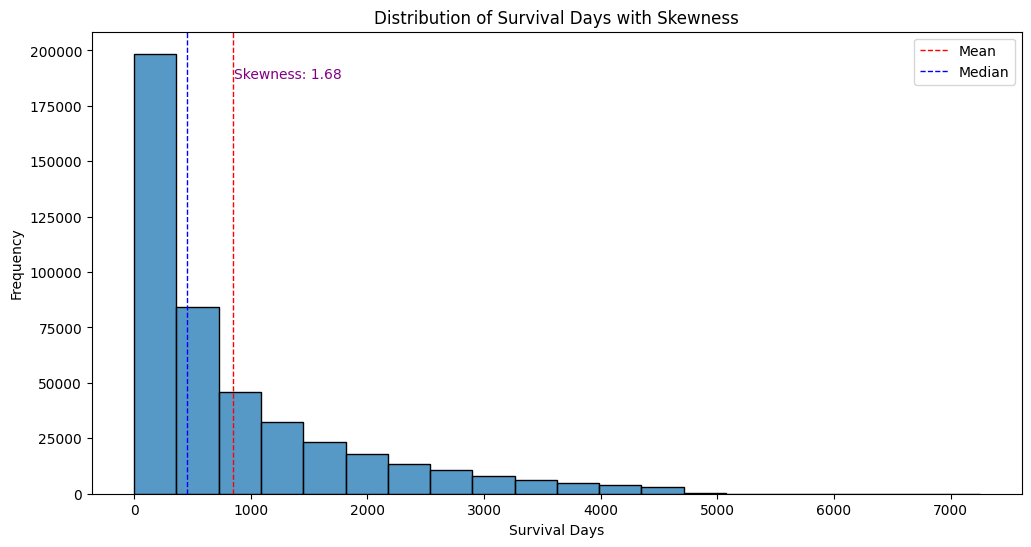



Interpretation

The histogram is right-skewed, indicating that most patients have shorter survival times, with fewer patients surviving longer periods. 
The red dashed line marks the mean survival time, while the blue dashed line indicates the median. The annotated skewness value quantifies 
the asymmetry and a positive skewness confirms the right-skewed distribution. 

This skewness suggests that while many patients have relatively short survival times, a smaller subset survives significantly longer, which could 
be important for understanding patient prognosis and planning treatment strategies.

SMOTE (Synthetic Minority Over-sampling Technique) will be applied to balance the data before modelling. By balancing the data using SMOTE, it will
make it easier for the machine learning to learn from both classes and improve its ability to generalize and predict accurately.




In [119]:
from scipy.stats import skew

# Plot histogram of Survival Months
plt.figure(figsize=(12, 6))
sb.histplot(Lung_cancer['Survival Days'], bins=20, kde=False)

# Calculate skewness
skewness_value = skew(Lung_cancer['Survival Days'].dropna())

# Add vertical lines for mean and median
plt.axvline(Lung_cancer['Survival Days'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(Lung_cancer['Survival Days'].median(), color='blue', linestyle='dashed', linewidth=1, label='Median')

# Annotate skewness
plt.text(Lung_cancer['Survival Days'].mean() + 5, plt.ylim()[1] * 0.9, 'Skewness: {:.2f}'.format(skewness_value), color='purple')

plt.title('Distribution of Survival Days with Skewness')
plt.xlabel('Survival Days')
plt.ylabel('Frequency')
plt.legend()
plt.show()


print("""

Interpretation

The histogram is right-skewed, indicating that most patients have shorter survival times, with fewer patients surviving longer periods. 
The red dashed line marks the mean survival time, while the blue dashed line indicates the median. The annotated skewness value quantifies 
the asymmetry and a positive skewness confirms the right-skewed distribution. 

This skewness suggests that while many patients have relatively short survival times, a smaller subset survives significantly longer, which could 
be important for understanding patient prognosis and planning treatment strategies.

SMOTE (Synthetic Minority Over-sampling Technique) will be applied to balance the data before modelling. By balancing the data using SMOTE, it will
make it easier for the machine learning to learn from both classes and improve its ability to generalize and predict accurately.

""")

In [120]:
# We have checked how skewed the data is, but we will need to plot a bar chart to know the number of patients that survived by survival category

# Creating target variables based on 'Survival Days'
conditions = [
    Lung_cancer['Survival Days'] < 730,
    (Lung_cancer['Survival Days'] >= 730) & (Lung_cancer['Survival Days'] < 1825),
    Lung_cancer['Survival Days'] >= 1825
]
choices = ['Survival_<2yrs', 'Survival_>=2yrs_to_<5yrs', 'Survival_>=5yrs']

# Creating a new column 'Survival Category'
Lung_cancer['Survival Category'] = pd.cut(Lung_cancer['Survival Days'], bins=[-1, 730, 1825, float('inf')], labels=choices)

# Displaying the head of the updated dataframe to confirm the new column
print(Lung_cancer[['Survival Days', 'Survival Category']].head())

   Survival Days         Survival Category
0           1796  Survival_>=2yrs_to_<5yrs
1             91            Survival_<2yrs
2            883  Survival_>=2yrs_to_<5yrs
3            822  Survival_>=2yrs_to_<5yrs
4           1583  Survival_>=2yrs_to_<5yrs


C:\Users\okemi\AppData\Local\Temp\ipykernel_24100\4029399716.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='Survival Category', data=Lung_cancer, palette='Set1')


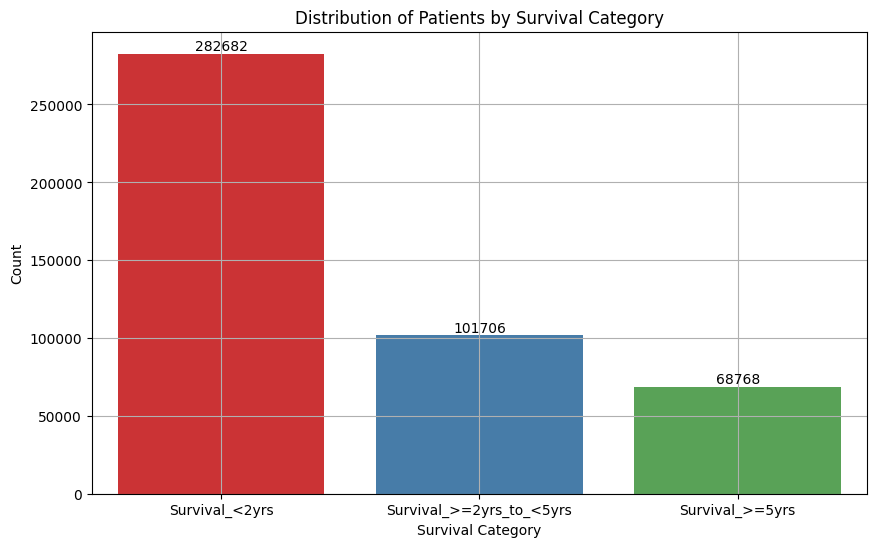


Intepretation

The chart shows that a significant number (358,013) of patients did not survive beyond two years, only 114,248 patients managed to survived between 
two to five years after diagnosis, while survival_>=5yrs shows the lowest count of survival patients who survived more than five years. This shows how 
challenging and deadly lung cancer is.


In [121]:
# Plotting the distribution of patients across survival categories
plt.figure(figsize=(10, 6))
sb.countplot(x='Survival Category', data=Lung_cancer, palette='Set1')
plt.title('Distribution of Patients by Survival Category')
plt.xlabel('Survival Category')
plt.ylabel('Count')
plt.grid(True)

# Adding data labels on top of the bars
for p in plt.gca().patches:
    plt.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom')

plt.show()

print("""
Intepretation

The chart shows that a significant number (358,013) of patients did not survive beyond two years, only 114,248 patients managed to survived between 
two to five years after diagnosis, while survival_>=5yrs shows the lowest count of survival patients who survived more than five years. This shows how 
challenging and deadly lung cancer is.""")

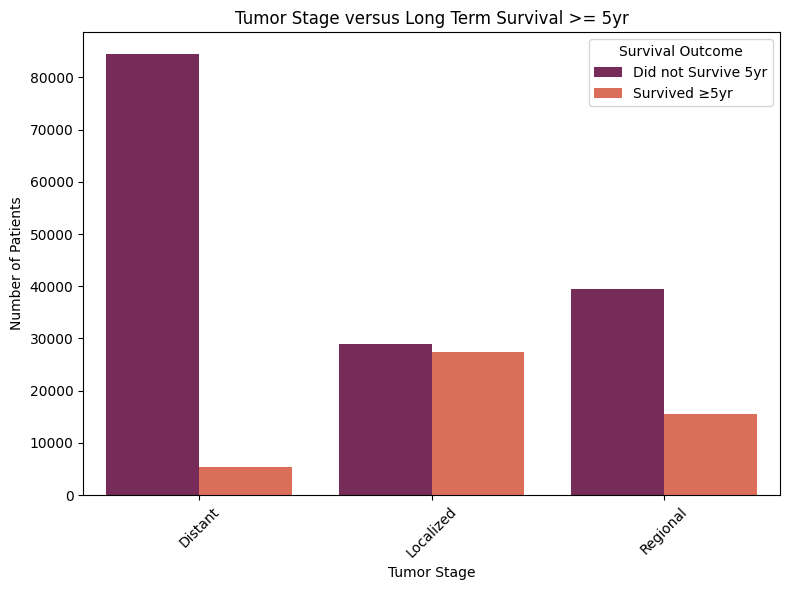



Insight from the chart

Majority of the patients diagnosed at the Distant stage did not survive beyond 5 years, while only a few survived beyond 5rys.

There is a balanced distribution of patients who survived beyond 5 years and patients who did not survive beyond 5 years. This tells us that  
if the lung cancer is detected and treated at an early stage, there is a likelihood that the patient will survive beyond 5 years.

Most patients did not survive beyond 5 years for patients who are diagnosed at the Regional stage, while a small number of patients 
survived beyond 5 years.


In [122]:
# We need to plot a bar chart for Tumor Stage and Survival Days. We need to know how the tumor stage relates to long-term survival
# and also if the advanced stage tumor stage has a few survival, or more survival, and if the early stage is likely to survive more or not.


# Temporary column created for survival category
Lung_cancer['Survival_>=5yr_temp'] = (Lung_cancer['Survival Days'] >= 1825).map({True: 'Survived ≥5yr', False: 'Did not Survive 5yr'})

# Filtering out the 'Unknown' tumor stage for better visualization clarity because filtering out will improve the interpretability of the visual
plot_data = Lung_cancer[Lung_cancer['Tumor Stage'] != 'Unknown']

# Plotting stacked bar chart
plt.figure(figsize=(8, 6))
sb.countplot(data=plot_data, x='Tumor Stage', hue='Survival_>=5yr_temp', palette='rocket')
plt.title("Tumor Stage versus Long Term Survival >= 5yr")
plt.xlabel("Tumor Stage")
plt.ylabel("Number of Patients")
plt.legend(title="Survival Outcome")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Drop the temporary column after use
Lung_cancer.drop(columns='Survival_>=5yr_temp', inplace=True)

print("""

Insight from the chart

Majority of the patients diagnosed at the Distant stage did not survive beyond 5 years, while only a few survived beyond 5rys.

There is a balanced distribution of patients who survived beyond 5 years and patients who did not survive beyond 5 years. This tells us that  
if the lung cancer is detected and treated at an early stage, there is a likelihood that the patient will survive beyond 5 years.

Most patients did not survive beyond 5 years for patients who are diagnosed at the Regional stage, while a small number of patients 
survived beyond 5 years.""")

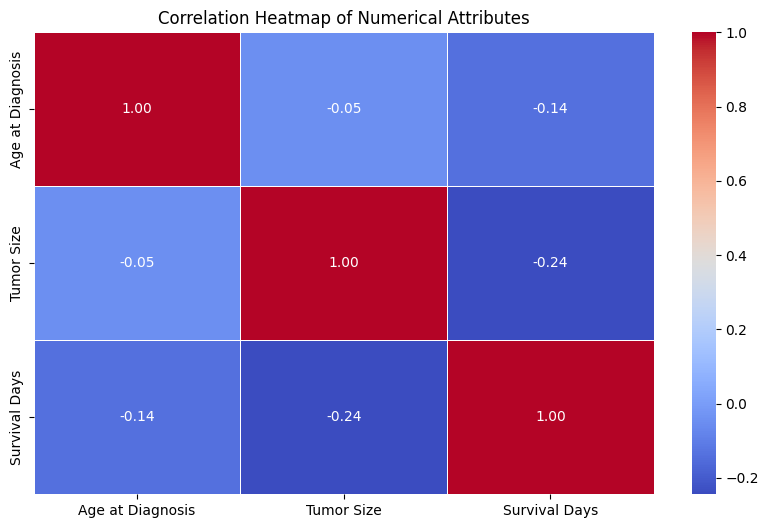



Insight from the chart

Age vs Survival Days is -0.14: this shows a weak negative relationship between the attributes, and this suggests that the older patients tend to have
a shorter survival.

Tumor Size vs Survival Days is -0.22: there is a strong negative relationship between Tumor size and Survival Days, and this suggests that when there
is a large tumor size, there will be a decrease in survival.

Age at Diagnosis vs Tumor size is -0.05: there is nearly no relationship between the two, and this suggests that Age at Diagnosis and Tumor size 
are independent.

In summary, it shows that none of the attributes has a strong positive correlation, which is good, and all attributes can be retained and
used for modelling.




In [123]:
# Plotting a correlation matrix to know the relationship between the numerical values. This will help us to know if there is a high correlation between 
# the independent variables, because having a high correlation between the independent variables can make it difficult to determine the individual  
# effect of each predictor on the dependent variable


# Numerical columns selected only
numerical_attributes = ['Age at Diagnosis', 'Tumor Size', 'Survival Days']
correlation_matrix = Lung_cancer[numerical_attributes].corr()

# Ploting the heatmap
plt.figure(figsize=(10, 6))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Attributes")
plt.show()

print("""

Insight from the chart

Age vs Survival Days is -0.14: this shows a weak negative relationship between the attributes, and this suggests that the older patients tend to have
a shorter survival.

Tumor Size vs Survival Days is -0.22: there is a strong negative relationship between Tumor size and Survival Days, and this suggests that when there
is a large tumor size, there will be a decrease in survival.

Age at Diagnosis vs Tumor size is -0.05: there is nearly no relationship between the two, and this suggests that Age at Diagnosis and Tumor size 
are independent.

In summary, it shows that none of the attributes has a strong positive correlation, which is good, and all attributes can be retained and
used for modelling.

""")

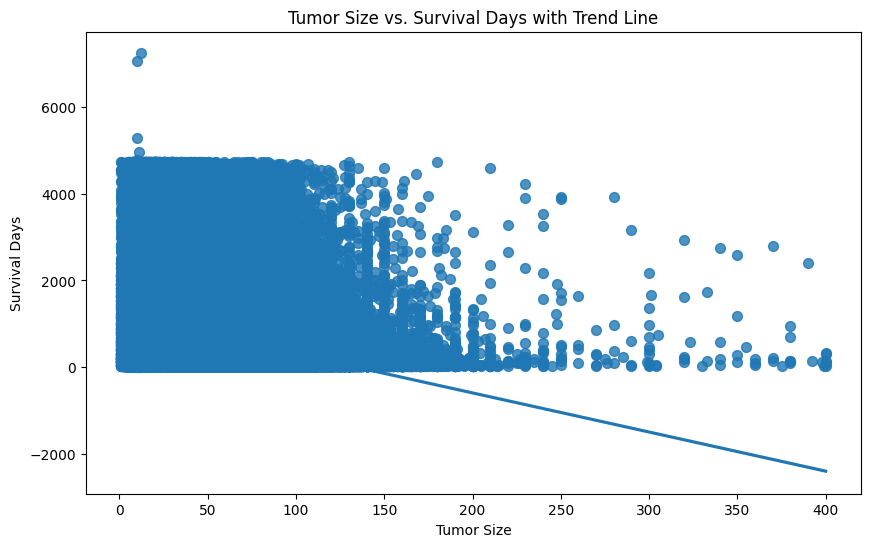



Insight from the chart
This trend line slopes downward, indicating a negative correlation, which means that larger tumors tend to be associated with shorter survival times
while some patients with small tumor size have very long survival > 5years. The trend line indicates that as tumor size increases, 
survival months generally decrease, supporting the hypothesis that tumor size is a significant prognostic factor. 

This scatter plot finally indicates that early detection of smaller tumor szie could potentially lead to better survival outcomes.




In [124]:
# Filter out negative survival days
filtered_data = Lung_cancer[Lung_cancer['Survival Days'] >= 0]

# Scatter plot with trend line for Tumor Size vs. Survival Months
plt.figure(figsize=(10, 6))
sb.regplot(x='Tumor Size', y='Survival Days', data=filtered_data, scatter_kws={'s':50})
plt.title('Tumor Size vs. Survival Days with Trend Line')
plt.xlabel('Tumor Size')
plt.ylabel('Survival Days')
plt.show()

print("""

Insight from the chart
This trend line slopes downward, indicating a negative correlation, which means that larger tumors tend to be associated with shorter survival times
while some patients with small tumor size have very long survival > 5years. The trend line indicates that as tumor size increases, 
survival months generally decrease, supporting the hypothesis that tumor size is a significant prognostic factor. 

This scatter plot finally indicates that early detection of smaller tumor szie could potentially lead to better survival outcomes.

""")

C:\Users\okemi\AppData\Local\Temp\ipykernel_24100\4037239171.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_unknown['Tumor Stage Numeric'] = filtered_unknown['Tumor Stage'].map(stage_mapping)


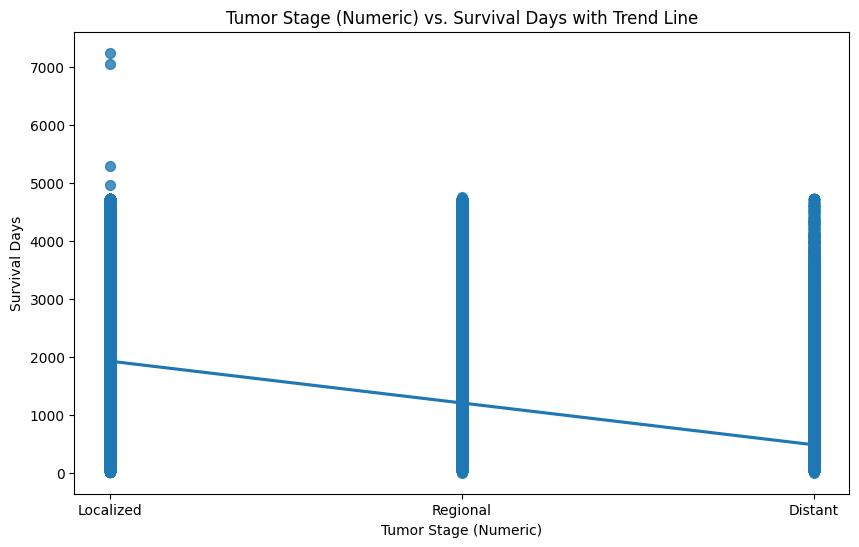



Insight

The chart shows the relationship between tumor stage and survival months, with the 'Unknown' category removed to focus only on well-defined 
stages: 'Localized', 'Regional', and 'Distant'. The x-axis labels these stages numerically from 1 to 3, and the trend line indicates how survival 
times tend to decrease as the tumor stage progresses.

The chart shows a downward trend line, which suggests that patients with more advanced tumor stages (like 'Distant') generally have shorter 
survival, while patients with localized tumors generally survive longer than those with regional or distant tumors.

In summary, the results emphasize the need for early detection, effective treatment strategies, and highlight the critical role of tumor stage in 
determine patients' outcomes.




In [125]:
# Filter out 'Unknown' tumor stages
filtered_unknown = Lung_cancer[Lung_cancer['Tumor Stage'] != 'Unknown']

# Map 'Tumor Stage' categories to numerical values for regression analysis
stage_mapping = {'Localized': 1, 'Regional': 2, 'Distant': 3}
filtered_unknown['Tumor Stage Numeric'] = filtered_unknown['Tumor Stage'].map(stage_mapping)

# Plotting Tumor Stage (numeric) vs. Survival Days with trend line for filtered data
plt.figure(figsize=(10, 6))
sb.regplot(x='Tumor Stage Numeric', y='Survival Days', data=filtered_unknown, scatter_kws={'s':50})
plt.title('Tumor Stage (Numeric) vs. Survival Days with Trend Line')
plt.xlabel('Tumor Stage (Numeric)')
plt.ylabel('Survival Days')
plt.xticks(ticks=[1, 2, 3], labels=['Localized', 'Regional', 'Distant'])
plt.show()

print("""

Insight

The chart shows the relationship between tumor stage and survival months, with the 'Unknown' category removed to focus only on well-defined 
stages: 'Localized', 'Regional', and 'Distant'. The x-axis labels these stages numerically from 1 to 3, and the trend line indicates how survival 
times tend to decrease as the tumor stage progresses.

The chart shows a downward trend line, which suggests that patients with more advanced tumor stages (like 'Distant') generally have shorter 
survival, while patients with localized tumors generally survive longer than those with regional or distant tumors.

In summary, the results emphasize the need for early detection, effective treatment strategies, and highlight the critical role of tumor stage in 
determine patients' outcomes.

""")

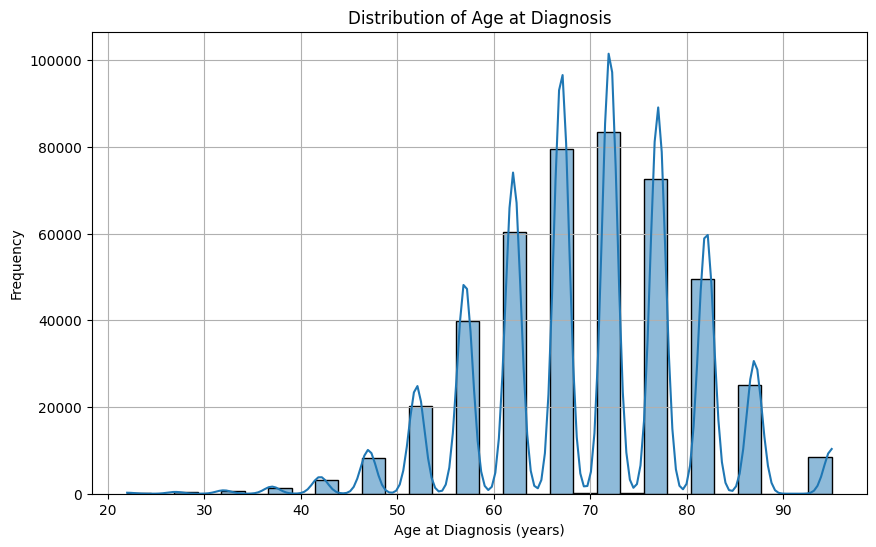


Insight

The chart shows that the majority of patients are diagnosed between the ages of 60 and 80, with a noticeable peak around 70 years. 
There are fewer patients diagnosed below the age of 50, and the frequency decreases as age increases above 80.

This suggests that lung cancer is more common among older adults.




In [126]:
# Plotting the distribution of age at diagnosis

# Plotting a histogram for 'Age at Diagnosis'
plt.figure(figsize=(10, 6))
sb.histplot(Lung_cancer['Age at Diagnosis'], bins=30, kde=True)
plt.title('Distribution of Age at Diagnosis')
plt.xlabel('Age at Diagnosis (years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("""
Insight

The chart shows that the majority of patients are diagnosed between the ages of 60 and 80, with a noticeable peak around 70 years. 
There are fewer patients diagnosed below the age of 50, and the frequency decreases as age increases above 80.

This suggests that lung cancer is more common among older adults.

""")

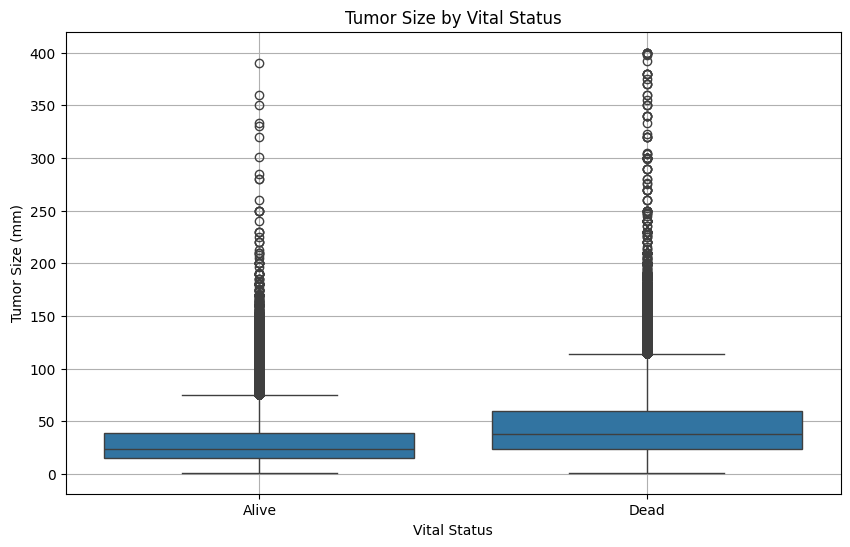


The box plot shows the distribution of tumor sizes in patients by their vital status.

The median tumor size for patients who are dead is higher than that for those who are alive, indicating that larger tumors may be associated with a 
higher likelihood of mortality, which aligns with clinical expectations that bigger tumors often indicate more advanced disease and poorer prognosis, 
while the interquartile range for dead patients is also wider, suggesting greater variability in tumor sizes among those who did 
not survive, and there are a few outliers in both categories, particularly among deceased patients, indicating some individuals had significantly 
larger tumors.




In [127]:
# Plotting a box plot for 'Tumor Size' by 'Vital Status'
plt.figure(figsize=(10, 6))
sb.boxplot(x='Vital Status', y='Tumor Size', data=Lung_cancer)
plt.title('Tumor Size by Vital Status')
plt.xlabel('Vital Status')
plt.ylabel('Tumor Size (mm)')
plt.grid(True)
plt.show()

print("""
The box plot shows the distribution of tumor sizes in patients by their vital status.

The median tumor size for patients who are dead is higher than that for those who are alive, indicating that larger tumors may be associated with a 
higher likelihood of mortality, which aligns with clinical expectations that bigger tumors often indicate more advanced disease and poorer prognosis, 
while the interquartile range for dead patients is also wider, suggesting greater variability in tumor sizes among those who did 
not survive, and there are a few outliers in both categories, particularly among deceased patients, indicating some individuals had significantly 
larger tumors.

""")

In [128]:
# Calculate average survival months for each treatment type
avg_survival_by_treatment = Lung_cancer.groupby('Treatment Type')['Survival Days'].mean().reset_index().round(2)

# Show the table
avg_survival_by_treatment

,Treatment Type,Survival Days
0,Chemotherapy,744.4
1,Combined,930.66
2,None,377.09
3,Radiation,680.48
4,Surgery,1642.68


C:\Users\okemi\AppData\Local\Temp\ipykernel_24100\3998985882.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Treatment Type', y='Survival Days', data=avg_survival_by_treatment, palette='viridis')


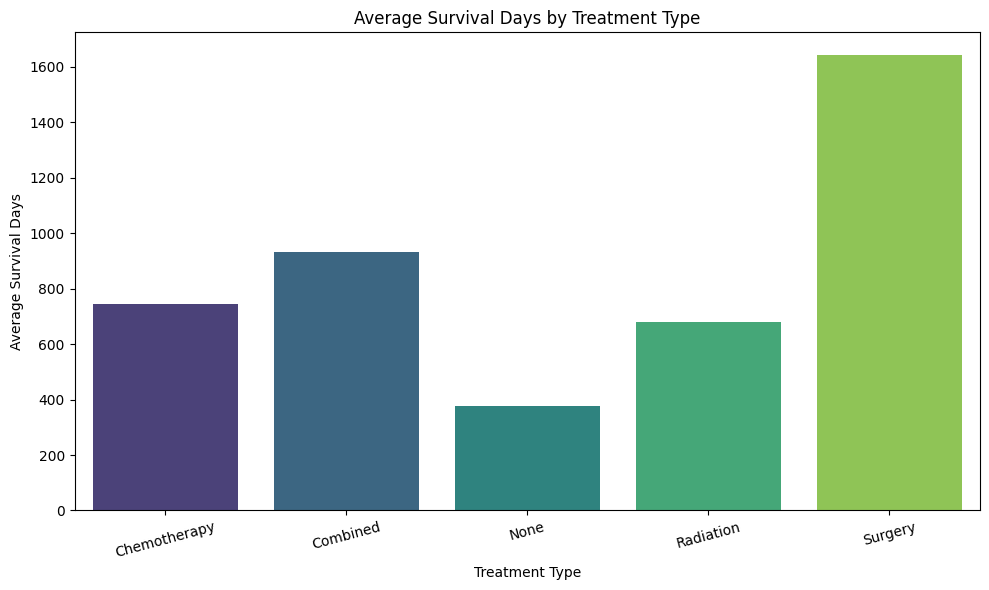



Insight

The chart compares the average survival months across different treatment types. The chart shows that patients who underwent surgery tend to have 
the longest average survival, followed by those receiving combined treatments. Chemotherapy and radiation treatments show shorter average 
survival times, with chemotherapy slightly lower. The visual makes it easy to see these differences at a glance, providing a quick summary 
of how treatment modality might influence patient outcomes.




In [129]:
# Plotting the average survival months for each treatment type
plt.figure(figsize=(10, 6))
sb.barplot(x='Treatment Type', y='Survival Days', data=avg_survival_by_treatment, palette='viridis')
plt.title('Average Survival Days by Treatment Type')
plt.xlabel('Treatment Type')
plt.ylabel('Average Survival Days')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

print("""

Insight

The chart compares the average survival months across different treatment types. The chart shows that patients who underwent surgery tend to have 
the longest average survival, followed by those receiving combined treatments. Chemotherapy and radiation treatments show shorter average 
survival times, with chemotherapy slightly lower. The visual makes it easy to see these differences at a glance, providing a quick summary 
of how treatment modality might influence patient outcomes.

""")

C:\Users\okemi\AppData\Local\Temp\ipykernel_24100\2346454364.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=average_survival_by_stage_filtered.index, y=average_survival_by_stage_filtered.values, palette='coolwarm')


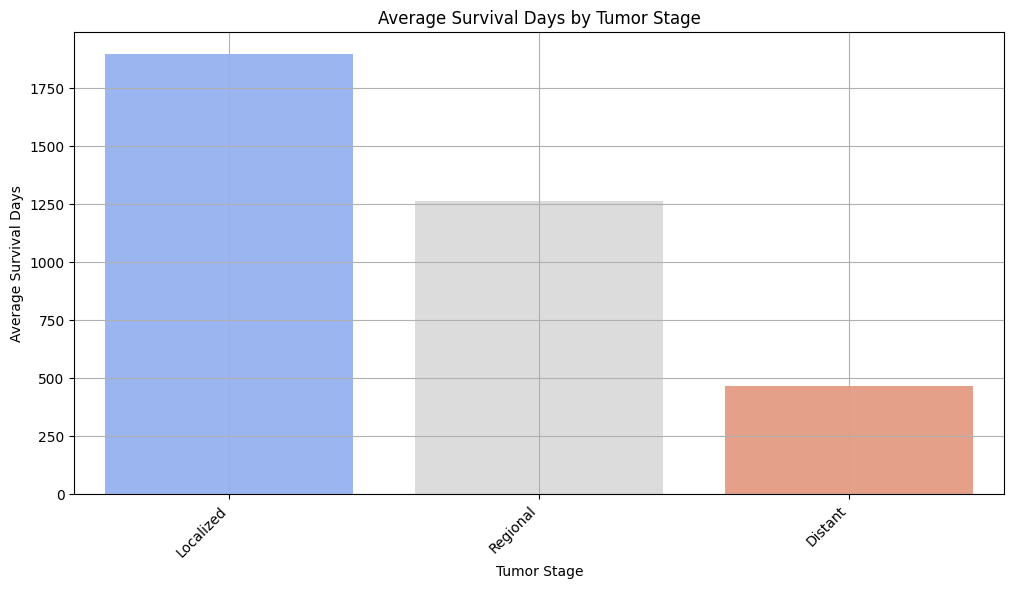


The chart shows that patients with a tumor stage localized have the highest average survival days, which indicates that early detection stage of 
lung cancer is crucial for better outcomes, while patients with tumor stage regional and distant are significantly lower, reinforcing the importance 
of early intervention.

In summary, the results emphasize the need for early detection, effective treatment strategies, and also highlight the critical role of tumor stage in 
determine patients' outcomes.




In [130]:
# plotting a chart to know the average survival days by tumor stage

# Filtering out rows with 'Unknown' tumor stage
filtered_cancer = Lung_cancer[Lung_cancer['Tumor Stage'] != 'Unknown']

# calculating the average survival days segmented by tumor stage after filtering
average_survival_by_stage_filtered = filtered_cancer.groupby('Tumor Stage')['Survival Days'].mean().sort_values(ascending=False)

# Plotting the average survival days for each tumor stage after filtering
plt.figure(figsize=(12, 6))
sb.barplot(x=average_survival_by_stage_filtered.index, y=average_survival_by_stage_filtered.values, palette='coolwarm')
plt.title('Average Survival Days by Tumor Stage')
plt.xlabel('Tumor Stage')
plt.ylabel('Average Survival Days')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

print("""
The chart shows that patients with a tumor stage localized have the highest average survival days, which indicates that early detection stage of 
lung cancer is crucial for better outcomes, while patients with tumor stage regional and distant are significantly lower, reinforcing the importance 
of early intervention.

In summary, the results emphasize the need for early detection, effective treatment strategies, and also highlight the critical role of tumor stage in 
determine patients' outcomes.

""")

## Data Modelling

In [131]:
Lung_cancer.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Vital Status,Survival Days,Survival Category
0,67,Unknown,70,Chemotherapy,Alive,1796,Survival_>=2yrs_to_<5yrs
1,77,Distant,30,None,Dead,91,Survival_<2yrs
2,67,Localized,30,None,Dead,883,Survival_>=2yrs_to_<5yrs
3,67,Unknown,109,Chemotherapy,Dead,822,Survival_>=2yrs_to_<5yrs
4,82,Localized,28,Surgery,Dead,1583,Survival_>=2yrs_to_<5yrs


In [132]:
# dropping the vital status which is not need for modelling because we are not predicting if the patient was alive or dead

Lung_cancer.drop(columns=["Vital Status"], inplace=True)

In [133]:
Lung_cancer.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Survival Days,Survival Category
0,67,Unknown,70,Chemotherapy,1796,Survival_>=2yrs_to_<5yrs
1,77,Distant,30,None,91,Survival_<2yrs
2,67,Localized,30,None,883,Survival_>=2yrs_to_<5yrs
3,67,Unknown,109,Chemotherapy,822,Survival_>=2yrs_to_<5yrs
4,82,Localized,28,Surgery,1583,Survival_>=2yrs_to_<5yrs


In [134]:
Lung_cancer.isnull().sum()

Age at Diagnosis     0
Tumor Stage          0
Tumor Size           0
Treatment Type       0
Survival Days        0
Survival Category    0
dtype: int64

In [135]:
# insatalling imbalanced-learn for SMOTE
#!pip install imbalanced-learn

In [136]:
#!pip install tensorflow

In [137]:
#!pip install shap

In [138]:
#!pip install xgboost

In [139]:
# Importing the necessary libaries for modelling 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.preprocessing import MultiLabelBinarizer
import shap
from tensorflow.keras.callbacks import EarlyStopping
#from imblearn.combine import SMOTETomek

In [140]:
Lung_cancer.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Survival Days,Survival Category
0,67,Unknown,70,Chemotherapy,1796,Survival_>=2yrs_to_<5yrs
1,77,Distant,30,None,91,Survival_<2yrs
2,67,Localized,30,None,883,Survival_>=2yrs_to_<5yrs
3,67,Unknown,109,Chemotherapy,822,Survival_>=2yrs_to_<5yrs
4,82,Localized,28,Surgery,1583,Survival_>=2yrs_to_<5yrs


In [141]:
# Based on our target variable, the survival days will be split into three columns as an added column and the survival days
# will be dropped.

# creating the new columns based on the survival threshold
# Better approach for multi-output - mutually exclusive categories
Lung_cancer['Survival_<2yrs'] = (Lung_cancer['Survival Days'] < 730).astype(int)
Lung_cancer['Survival_>=2yrs_<5yrs'] = ((Lung_cancer['Survival Days'] >= 730) & (Lung_cancer['Survival Days'] < 1825)).astype(int)
Lung_cancer['Survival_>=5yrs'] = (Lung_cancer['Survival Days'] >= 1825).astype(int)

In [142]:
# Dropping the survival days column

Lung_cancer = Lung_cancer.drop(columns=['Survival Days'])
Lung_cancer = Lung_cancer.drop(columns=['Survival Category'])

In [143]:
Lung_cancer.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Survival_<2yrs,Survival_>=2yrs_<5yrs,Survival_>=5yrs
0,67,Unknown,70,Chemotherapy,0,1,0
1,77,Distant,30,None,1,0,0
2,67,Localized,30,None,0,1,0
3,67,Unknown,109,Chemotherapy,0,1,0
4,82,Localized,28,Surgery,0,1,0


In [144]:
# converting the Tumor Stage to numeric or binary

le= LabelEncoder()
Lung_cancer['Tumor Stage'] = le.fit_transform(Lung_cancer['Tumor Stage'])
Lung_cancer['Treatment Type'] = le.fit_transform(Lung_cancer['Treatment Type'])

In [145]:
Lung_cancer.head()

,Age at Diagnosis,Tumor Stage,Tumor Size,Treatment Type,Survival_<2yrs,Survival_>=2yrs_<5yrs,Survival_>=5yrs
0,67,3,70,0,0,1,0
1,77,0,30,2,1,0,0
2,67,1,30,2,0,1,0
3,67,3,109,0,0,1,0
4,82,1,28,4,0,1,0


In [146]:
# Assigning the variable to X and y
X = Lung_cancer.drop(['Survival_<2yrs', 'Survival_>=2yrs_<5yrs', 'Survival_>=5yrs'], axis=1)
y = Lung_cancer[['Survival_<2yrs', 'Survival_>=2yrs_<5yrs', 'Survival_>=5yrs']]

In [147]:
# Splitting the dataset into test and train varaible
# X- variables - predictors, the features that helps to predicct the target variable
# Y- target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
# Applying SMOTE on the trainig data only
# Note: SMOTE does not work for multilabel target but only works for single target. 
# for this, we will apply the SMOTE seperately to earh target column

def smote_multilabel_clean(X_train, y_train, random_state=42):
    X_resampled_list = []
    y_resampled_list = []

    # Convert to numeric types explicitly
    X_train_numeric = X_train.select_dtypes(include=[np.number]).astype(np.float64)

    for label in y_train.columns:
        y_clean = y_train[label].fillna(0).round().astype(int)

        # Manual sampling strategies
        if label == "Survival_>=5yrs":
            smote = SMOTE(sampling_strategy=0.8, random_state=random_state)  # More aggressive for rare class
        elif label == "Survival_>=2yrs_<5yrs":
            smote = SMOTE(sampling_strategy=0.9, random_state=random_state)  # Moderate resampling
        else:
            smote = SMOTE(sampling_strategy='auto', random_state=random_state)

        # Apply SMOTE for current label
        X_res, y_res = smote.fit_resample(X_train_numeric, y_clean)
        X_resampled_list.append(X_res)
        y_resampled_list.append(y_res)

    # Align all outputs to the shortest sample length
    min_len = min(len(x) for x in X_resampled_list)
    X_train_final = pd.DataFrame(X_resampled_list[0][:min_len], columns=X_train_numeric.columns)
    y_train_final = pd.DataFrame(
        np.column_stack([y[:min_len] for y in y_resampled_list]),
        columns=y_train.columns
    )

    return X_train_final, y_train_final, X_train_numeric.columns

In [149]:
# fitting the scaler only on the training data

# Applying SMOTE before scaling
X_train_resampled, y_train_resampled, used_cols = smote_multilabel_clean(X_train, y_train)

# Scaling trained data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Scale test set using the same columns and scaler
X_test_numeric = X_test[used_cols].astype(np.float64)
X_test_scaled = scaler.transform(X_test_numeric)

#### Modelling using Random Forest Classifier

In [150]:
# fit in the modelling into the Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: 1.5})
multi_rfc = MultiOutputClassifier(rfc)
multi_rfc.fit(X_train_scaled , y_train_resampled)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight={0: 1,
                                                                     1: 1.5},
                                                       random_state=42))

#### Modelling using XGBoost (XGB)

In [151]:
xgb = XGBClassifier(
    n_estimators=700,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=6,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.6,
    scale_pos_weight=3.45,
    eval_metric='aucpr',
    random_state=42,
    use_label_encoder=False
)

multi_xgb = MultiOutputClassifier(xgb)
multi_xgb.fit(X_train_scaled, y_train_resampled)

C:\Users\okemi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:15:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\okemi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:16:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\okemi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:16:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='aucpr',
                                              feature_types=None,
                                              feature_weights=None, gamma=0.2,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.03, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=6, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=700, n_jobs=None,
                                              num_parallel_tree=None, ...))

#### Modelling using Deep Neural Network (DNN)

In [167]:

# Keep original labels
target_columns = y_train_resampled.columns.tolist()

# Input layer
inputs = Input(shape=(X_train_scaled.shape[1],))

# Deeper hidden layers
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

# Output layers
outputs = [Dense(1, activation='sigmoid', name=f'output_{i}')(x) for i in range(len(target_columns))]

# Compile model with label-specific loss weight boost for 2–5 year class (index 1)
model = Model(inputs=inputs, outputs=outputs)
loss_weights = [1.0, 2.0, 1.0]  # Boost for 2nd label
model.compile(
    optimizer=Adam(),
    loss=['binary_crossentropy'] * len(target_columns),
    metrics=['accuracy'] * len(target_columns),
    loss_weights=loss_weights
)

# Sample weights
sample_weights_list = []
for col in target_columns:
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train_resampled[col]
    )
    weights = {0: class_weights[0], 1: class_weights[1]}
    sample_weights = y_train_resampled[col].map(weights).astype(np.float32)
    sample_weights_list.append(sample_weights.values)

# Fit the model with EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    [y_train_resampled[col].values for col in target_columns],
    sample_weight=sample_weights_list,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/30
11314/11314 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 2.0782 - output_0_accuracy: 0.7058 - output_0_loss: 0.5722 - output_1_accuracy: 0.7610 - output_1_loss: 0.5504 - output_2_accuracy: 0.8592 - output_2_loss: 0.4051 - val_loss: 5.7160 - val_output_0_accuracy: 0.5166 - val_output_0_loss: 0.8177 - val_output_1_accuracy: 0.1798 - val_output_1_loss: 1.4174 - val_output_2_accuracy: 0.3015 - val_output_2_loss: 2.0634
Epoch 2/30
11314/11314 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - loss: 2.0086 - output_0_accuracy: 0.7249 - output_0_loss: 0.5493 - output_1_accuracy: 0.7605 - output_1_loss: 0.5379 - output_2_accuracy: 0.8551 - output_2_loss: 0.3836 - val_loss: 5.8893 - val_output_0_accuracy: 0.5053 - val_output_0_loss: 0.8648 - val_output_1_accuracy: 0.1768 - val_output_1_loss: 1.4501 - val_output_2_accuracy: 0.2730 - val_output_2_loss: 2.1241
Epoch 3/30
11314/11314 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 2.0012 - output_0_accuracy: 0.7262 - output_0_loss: 0.5474 - output_1_accuracy: 0

### Predicting and Evaluation

In [153]:
#!pip install lifelines

In [154]:
# importing the necessary libraries

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
from lifelines.utils import concordance_index

### Random Forest Classifier

In [155]:
# Predicting X_test using the Random Forest Classifier multi-output model
y_pred_rfc = multi_rfc.predict(X_test_scaled)

# Evaluating the performance for each label
for i, label in enumerate(y.columns):
    print(f"\n--- Random Forest - {label} ---")
    acc = accuracy_score(y_test[label], y_pred_rfc[:, i])
    prec = precision_score(y_test[label], y_pred_rfc[:, i])
    rec = recall_score(y_test[label], y_pred_rfc[:, i])
    f1 = f1_score(y_test[label], y_pred_rfc[:, i])
    roc = roc_auc_score(y_test[label], y_pred_rfc[:, i])
    cindex = concordance_index(y_test[label], y_pred_rfc[:, i])

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"ROC AUC: {roc:.2f}")
    print(f"Concordance Index: {cindex:.2f}")


--- Random Forest - Survival_<2yrs ---
Accuracy: 0.72
Precision: 0.75
Recall: 0.83
F1-score: 0.79
ROC AUC: 0.68
Concordance Index: 0.68

--- Random Forest - Survival_>=2yrs_<5yrs ---
Accuracy: 0.60
Precision: 0.31
Recall: 0.61
F1-score: 0.41
ROC AUC: 0.61
Concordance Index: 0.61

--- Random Forest - Survival_>=5yrs ---
Accuracy: 0.79
Precision: 0.39
Recall: 0.66
F1-score: 0.49
ROC AUC: 0.74
Concordance Index: 0.74


### XGBoost

In [157]:
# Predicting X_test using the XGBoost multi-output model

# Optional manual threshold shift for specific labels
threshold_shifts = {
    "Survival_>=2yrs_<5yrs": 0.08,   # Raise threshold for more precision
    "Survival_>=5yrs": -0.01,        # Lower threshold for more recall
}

# Evaluation loop
for i, label in enumerate(y.columns):
    print(f"\n--- XGBoost - {label} ---")
    model = multi_xgb.estimators_[i]
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test[label], y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    # Apply label-specific threshold adjustment
    shift = threshold_shifts.get(label, 0.05)  # default slight increase
    adjusted_threshold = np.clip(best_threshold + shift, 0.01, 0.99)

    y_pred = (y_prob >= adjusted_threshold).astype(int)

    acc = accuracy_score(y_test[label], y_pred)
    prec = precision_score(y_test[label], y_pred)
    rec = recall_score(y_test[label], y_pred)
    f1 = f1_score(y_test[label], y_pred)
    roc = roc_auc_score(y_test[label], y_prob)
    cindex = concordance_index(y_test[label], y_prob)

    #print(f"Adjusted Threshold: {adjusted_threshold:.2f}")
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"ROC AUC: {roc:.2f}")
    print(f"Concordance Index: {cindex:.2f}")


--- XGBoost - Survival_<2yrs ---
Accuracy: 0.73
Precision: 0.73
Recall: 0.88
F1-score: 0.80
ROC AUC: 0.78
Concordance Index: 0.78

--- XGBoost - Survival_>=2yrs_<5yrs ---
Accuracy: 0.62
Precision: 0.32
Recall: 0.60
F1-score: 0.42
ROC AUC: 0.67
Concordance Index: 0.67

--- XGBoost - Survival_>=5yrs ---
Accuracy: 0.83
Precision: 0.46
Recall: 0.59
F1-score: 0.52
ROC AUC: 0.82
Concordance Index: 0.82


### Deep Neural Network

In [168]:
# Predict probabilities
y_pred_dnn_raw = model.predict(X_test_scaled)

# Threshold tuning + evaluation
print("\n=== DNN Evaluation with Tuned Thresholds ===")
for i, label in enumerate(y.columns):
    y_true = y_test[label].values
    y_prob = y_pred_dnn_raw[i].flatten()

    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    # Optional: manually tweak thresholds per label (boost precision or recall)
    manual_adjust = {
        "Survival_>=2yrs_<5yrs": +0.06,   # Lower slightly to boost recall
        "Survival_>=5yrs": 0.00           # Keep threshold optimal
    }
    shift = manual_adjust.get(label, 0.00)
    threshold = np.clip(best_threshold + shift, 0.05, 0.95)

    # Apply threshold
    y_pred = (y_prob >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    cindex = concordance_index(y_true, y_prob)

    print(f"\n--- DNN - {label} ---")
    #print(f"Optimal Threshold: {threshold:.2f}")
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"ROC AUC: {roc:.2f}")
    print(f"Concordance Index: {cindex:.2f}")

2833/2833 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

=== DNN Evaluation with Tuned Thresholds ===

--- DNN - Survival_<2yrs ---
Accuracy: 0.72
Precision: 0.72
Recall: 0.91
F1-score: 0.80
ROC AUC: 0.77
Concordance Index: 0.77

--- DNN - Survival_>=2yrs_<5yrs ---
Accuracy: 0.67
Precision: 0.35
Recall: 0.53
F1-score: 0.42
ROC AUC: 0.68
Concordance Index: 0.68

--- DNN - Survival_>=5yrs ---
Accuracy: 0.85
Precision: 0.49
Recall: 0.56
F1-score: 0.52
ROC AUC: 0.83
Concordance Index: 0.83


In [161]:
# Count of 0s and 1s per column
count_df = y.apply(lambda col: col.value_counts()).T.fillna(0)
count_df.columns = ['Count_0', 'Count_1']

# Percentage distribution
percent_df = y.apply(lambda col: col.value_counts(normalize=True) * 100).T.fillna(0)
percent_df.columns = ['Percent_0', 'Percent_1']

# Combine both
distribution_df = count_df.join(percent_df)

# Round percentages to 2 decimal places
distribution_df = distribution_df.round(2)

print(distribution_df)

                       Count_0  Count_1  Percent_0  Percent_1
Survival_<2yrs          187771   355920      34.54      65.46
Survival_>=2yrs_<5yrs   429777   113914      79.05      20.95
Survival_>=5yrs         469834    73857      86.42      13.58


In [162]:
for col in y_train_resampled.columns:
    print(f"\nDistribution for {col}:")
    counts = y_train_resampled[col].value_counts()
    percentages = y_train_resampled[col].value_counts(normalize=True) * 100
    distribution_df = pd.concat([counts, percentages], axis=1)
    distribution_df.columns = ['Count', 'Percentage (%)']
    print(distribution_df)


Distribution for Survival_<2yrs:
                 Count  Percentage (%)
Survival_<2yrs                        
0               284627            50.0
1               284627            50.0

Distribution for Survival_>=2yrs_<5yrs:
                        Count  Percentage (%)
Survival_>=2yrs_<5yrs                        
0                      343741       60.384468
1                      225513       39.615532

Distribution for Survival_>=5yrs:
                  Count  Percentage (%)
Survival_>=5yrs                        
0                375838         66.0229
1                193416         33.9771


### SHAP (SHapley Additive exPlanations) Enhqnced into one

=== COMPREHENSIVE SHAP ANALYSIS FOR LUNG CANCER SURVIVAL PREDICTION ===

1. RANDOM FOREST CLASSIFIER SHAP ANALYSIS
Number of features used in training: 4
Training features: ['Age at Diagnosis', 'Tumor Stage', 'Tumor Size', 'Treatment Type']...

--- Survival_<2yrs (Random Forest) ---
Individual classifier type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Raw SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (500, 4, 2)
3D SHAP values detected - extracting positive class (index 1)
Final SHAP values for plotting shape: (500, 4)
Feature importance shape: (4,)
Feature importance type: <class 'numpy.ndarray'>
Converted to 4 scalar values


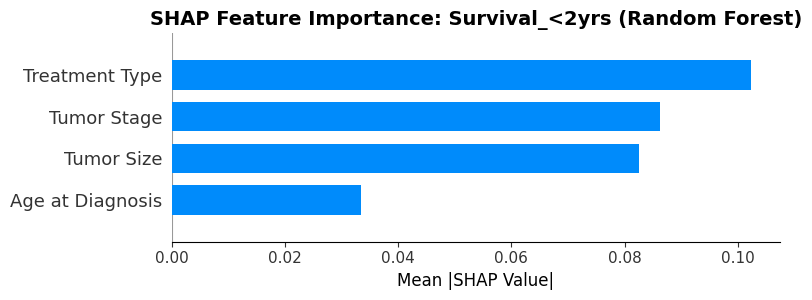


Top 5 Most Important Features for Survival_<2yrs:
  1. Treatment Type: 0.1024
  2. Tumor Stage: 0.0863
  3. Tumor Size: 0.0826
  4. Age at Diagnosis: 0.0335
✓ Top feature from calculation: Treatment Type (0.1024)

--- Survival_>=2yrs_<5yrs (Random Forest) ---
Individual classifier type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Raw SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (500, 4, 2)
3D SHAP values detected - extracting positive class (index 1)
Final SHAP values for plotting shape: (500, 4)
Feature importance shape: (4,)
Feature importance type: <class 'numpy.ndarray'>
Converted to 4 scalar values


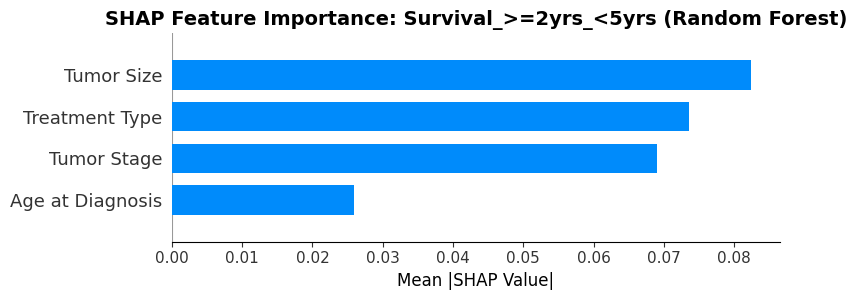


Top 5 Most Important Features for Survival_>=2yrs_<5yrs:
  1. Tumor Size: 0.0824
  2. Treatment Type: 0.0736
  3. Tumor Stage: 0.0690
  4. Age at Diagnosis: 0.0259
✓ Top feature from calculation: Tumor Size (0.0824)

--- Survival_>=5yrs (Random Forest) ---
Individual classifier type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Raw SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (500, 4, 2)
3D SHAP values detected - extracting positive class (index 1)
Final SHAP values for plotting shape: (500, 4)
Feature importance shape: (4,)
Feature importance type: <class 'numpy.ndarray'>
Converted to 4 scalar values


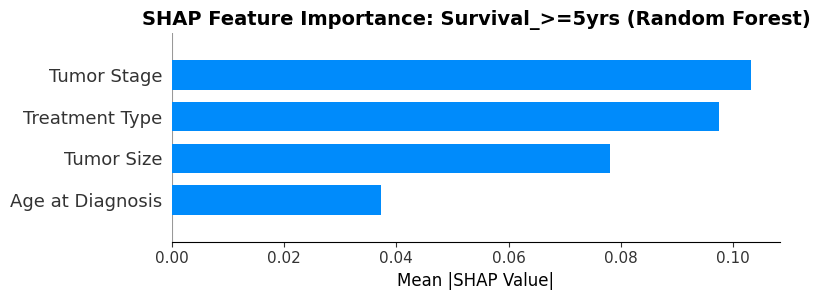


Top 5 Most Important Features for Survival_>=5yrs:
  1. Tumor Stage: 0.1032
  2. Treatment Type: 0.0975
  3. Tumor Size: 0.0781
  4. Age at Diagnosis: 0.0373
✓ Top feature from calculation: Tumor Stage (0.1032)

--- MODEL STRUCTURE VERIFICATION ---
MultiOutputClassifier estimators: 3
Training data shape: (452544, 4)
Test data shape for SHAP: (500, 4)
Background data shape: (200, 4)

--- PREDICTION TEST ---
Survival_<2yrs prediction shape: (3, 2)
Survival_>=2yrs_<5yrs prediction shape: (3, 2)
Survival_>=5yrs prediction shape: (3, 2)

--- END OF RANDOM FOREST SHAP ANALYSIS ---


2. XGBOOST SHAP ANALYSIS

--- Survival_<2yrs (XGBoost) ---


C:\Users\okemi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\okemi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\okemi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


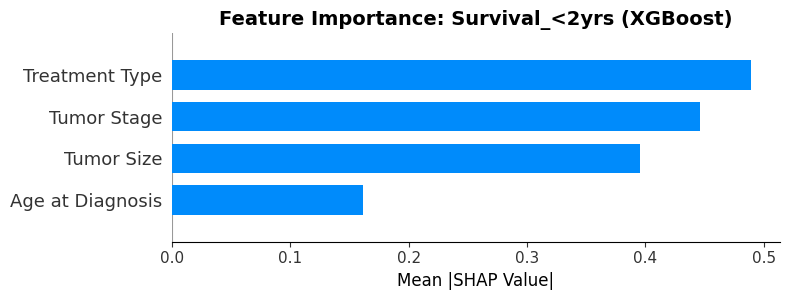

Top 5 Most Important Features for Survival_<2yrs:
  1. Treatment Type: 0.4892
  2. Tumor Stage: 0.4460
  3. Tumor Size: 0.3953
  4. Age at Diagnosis: 0.1618

--- Survival_>=2yrs_<5yrs (XGBoost) ---


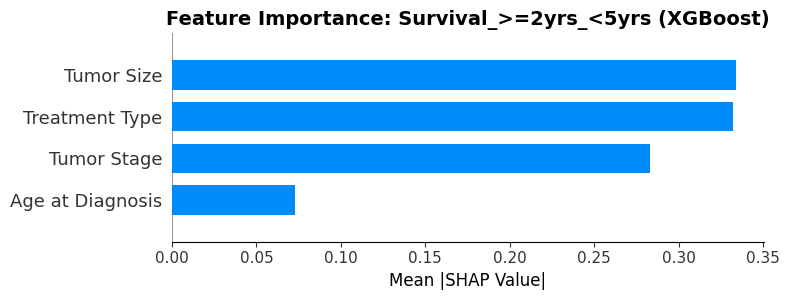

Top 5 Most Important Features for Survival_>=2yrs_<5yrs:
  1. Tumor Size: 0.3339
  2. Treatment Type: 0.3325
  3. Tumor Stage: 0.2830
  4. Age at Diagnosis: 0.0727

--- Survival_>=5yrs (XGBoost) ---


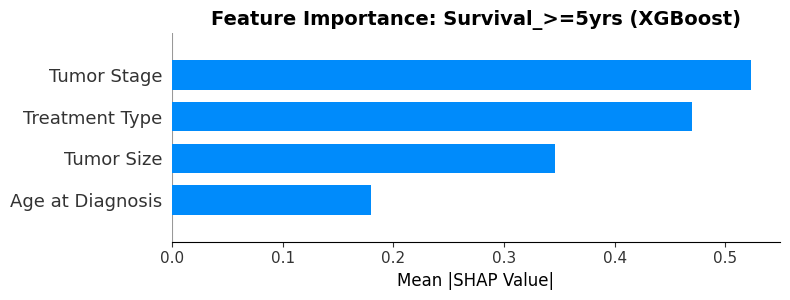

Top 5 Most Important Features for Survival_>=5yrs:
  1. Tumor Stage: 0.5232
  2. Treatment Type: 0.4702
  3. Tumor Size: 0.3457
  4. Age at Diagnosis: 0.1802


3. DEEP NEURAL NETWORK SHAP ANALYSIS
Debugging model output format...
Model prediction type: <class 'list'>
Number of outputs: 3
  Output 0 shape: (5, 1)
  Output 1 shape: (5, 1)
  Output 2 shape: (5, 1)

--- Survival_<2yrs (Deep Neural Network) ---
Single output function test - shape: (5,)


  0%|          | 0/100 [00:00<?, ?it/s]

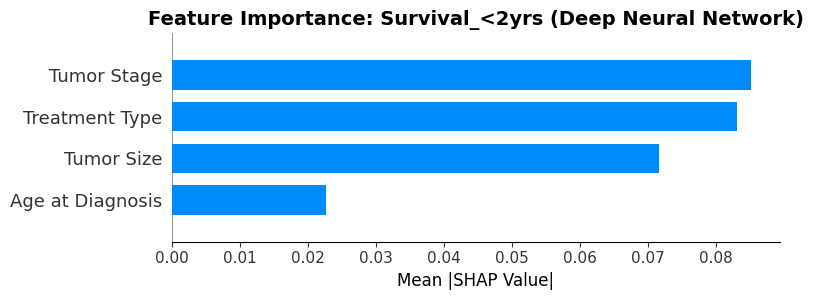

Top 5 Most Important Features for Survival_<2yrs:
  1. Tumor Stage: 0.0852
  2. Treatment Type: 0.0831
  3. Tumor Size: 0.0717
  4. Age at Diagnosis: 0.0227

--- Survival_>=2yrs_<5yrs (Deep Neural Network) ---
Single output function test - shape: (5,)


  0%|          | 0/100 [00:00<?, ?it/s]

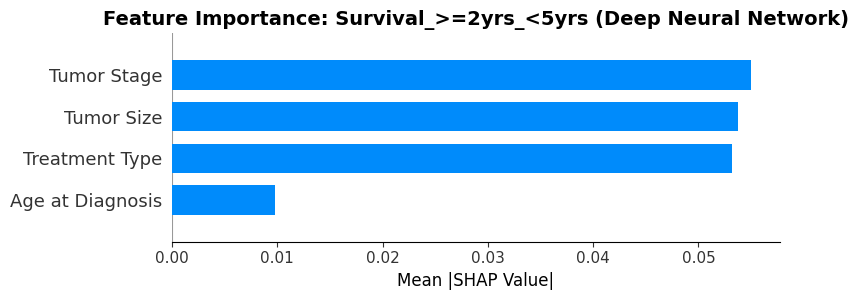

Top 5 Most Important Features for Survival_>=2yrs_<5yrs:
  1. Tumor Stage: 0.0550
  2. Tumor Size: 0.0538
  3. Treatment Type: 0.0532
  4. Age at Diagnosis: 0.0098

--- Survival_>=5yrs (Deep Neural Network) ---
Single output function test - shape: (5,)


  0%|          | 0/100 [00:00<?, ?it/s]

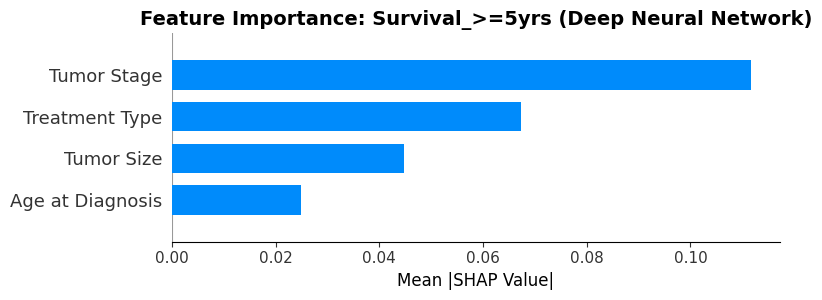

Top 5 Most Important Features for Survival_>=5yrs:
  1. Tumor Stage: 0.1117
  2. Treatment Type: 0.0672
  3. Tumor Size: 0.0447
  4. Age at Diagnosis: 0.0248


4. COMPREHENSIVE FEATURE IMPORTANCE COMPARISON

FEATURE IMPORTANCE SUMMARY BY SURVIVAL TIMEFRAME:
------------------------------------------------------------

SURVIVAL_<2YRS:
Top 5 Most Important Clinical Factors (Average across all models):
  1. Treatment Type:
     Average: 0.2249
     RF: 0.1024 | XGB: 0.4892 | DNN: 0.0831
  2. Tumor Stage:
     Average: 0.2058
     RF: 0.0863 | XGB: 0.4460 | DNN: 0.0852
  3. Tumor Size:
     Average: 0.1832
     RF: 0.0826 | XGB: 0.3953 | DNN: 0.0717
  4. Age at Diagnosis:
     Average: 0.0726
     RF: 0.0335 | XGB: 0.1618 | DNN: 0.0227

SURVIVAL_>=2YRS_<5YRS:
Top 5 Most Important Clinical Factors (Average across all models):
  1. Tumor Size:
     Average: 0.1567
     RF: 0.0824 | XGB: 0.3339 | DNN: 0.0538
  2. Treatment Type:
     Average: 0.1531
     RF: 0.0736 | XGB: 0.3325 | DNN: 0.0532

In [164]:
# %% [markdown]
# ### Enhanced SHAP (SHapley Additive exPlanations) Analysis

# %%
# Enhanced SHAP Analysis with proper visualization and feature importance

# Prepare data for SHAP analysis
X_shap_sample = pd.DataFrame(X_test_scaled[:500], columns=X_train.columns)  # Larger sample for better insights
X_background = pd.DataFrame(X_train_scaled[:200], columns=X_train.columns)  # Background for KernelExplainer

# Get proper feature names
feature_names = X_train.columns.tolist()
target_names = ['Survival_<2yrs', 'Survival_>=2yrs_<5yrs', 'Survival_>=5yrs']

# Create a comprehensive comparison dictionary
shap_importance_comparison = {}

print("=== COMPREHENSIVE SHAP ANALYSIS FOR LUNG CANCER SURVIVAL PREDICTION ===\n")

# %% [markdown]
# #### Random Forest Classifier SHAP Analysis




# %% [markdown]
# #### Fixed Random Forest Classifier SHAP Analysis for MultiOutputClassifier

# %%
print("1. RANDOM FOREST CLASSIFIER SHAP ANALYSIS")
print("=" * 50)

# Clear any existing plots
plt.close('all')

# IMPORTANT: Use the same columns that were used for training after SMOTE
# Get the feature names from the columns used in training
training_feature_names = used_cols.tolist()  # From your SMOTE function
print(f"Number of features used in training: {len(training_feature_names)}")
print(f"Training features: {training_feature_names[:5]}...")  # Show first 5

# Prepare SHAP data using the same feature columns as training
X_shap_sample_aligned = pd.DataFrame(X_test_scaled[:500], columns=training_feature_names)
X_background_aligned = pd.DataFrame(X_train_scaled[:200], columns=training_feature_names)

rfc_importance = {}
for i, target in enumerate(target_names):
    print(f"\n--- {target} (Random Forest) ---")
    
    # Get the individual RandomForestClassifier for this target
    individual_rfc = multi_rfc.estimators_[i]
    print(f"Individual classifier type: {type(individual_rfc)}")
    
    # Create explainer for the individual RandomForestClassifier
    explainer = shap.TreeExplainer(individual_rfc)
    shap_values = explainer.shap_values(X_shap_sample_aligned)
    
    # Handle SHAP values structure
    print(f"Raw SHAP values type: {type(shap_values)}")
    if isinstance(shap_values, list):
        print(f"SHAP values is a list with {len(shap_values)} elements")
        for idx, sv in enumerate(shap_values):
            print(f"  Element {idx} shape: {sv.shape}")
        # Use positive class (class 1) SHAP values
        shap_values_plot = shap_values[1]
    else:
        print(f"SHAP values shape: {shap_values.shape}")
        # Handle 3D case: (samples, features, classes)
        if len(shap_values.shape) == 3:
            print("3D SHAP values detected - extracting positive class (index 1)")
            shap_values_plot = shap_values[:, :, 1]  # Get positive class
        else:
            shap_values_plot = shap_values
    
    print(f"Final SHAP values for plotting shape: {shap_values_plot.shape}")
    
    # Calculate feature importance - should be 1D array of length = number of features
    feature_importance = np.abs(shap_values_plot).mean(axis=0)
    print(f"Feature importance shape: {feature_importance.shape}")
    print(f"Feature importance type: {type(feature_importance)}")
    
    # Ensure feature importance is 1D
    if len(feature_importance.shape) > 1:
        print("ERROR: Feature importance should be 1D but has multiple dimensions")
        print(f"Current shape: {feature_importance.shape}")
        continue
    
    # Convert to list of scalar values
    feature_importance_scalars = [float(val) for val in feature_importance]
    print(f"Converted to {len(feature_importance_scalars)} scalar values")
    
    # Ensure we have the right number of features
    if len(feature_importance_scalars) != len(training_feature_names):
        print(f"ERROR: Feature importance length ({len(feature_importance_scalars)}) doesn't match training features ({len(training_feature_names)})")
        continue
    
    # Store importance for comparison
    rfc_importance[target] = dict(zip(training_feature_names, feature_importance_scalars))
    
    # Create SHAP summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values_plot, 
        X_shap_sample_aligned, 
        feature_names=training_feature_names,
        plot_type="bar",
        max_display=min(15, len(training_feature_names)),  # Limit display for readability
        show=False
    )
    
    plt.title(f'SHAP Feature Importance: {target} (Random Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Mean |SHAP Value|', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Print top 5 features based on calculated importance
    try:
        sorted_features = sorted(rfc_importance[target].items(), key=lambda x: x[1], reverse=True)
        print(f"\nTop 5 Most Important Features for {target}:")
        for j, (feature, importance) in enumerate(sorted_features[:5], 1):
            print(f"  {j}. {feature}: {importance:.4f}")
        
        # Verify that top feature matches
        top_from_calc = sorted_features[0][0]
        print(f"✓ Top feature from calculation: {top_from_calc} ({sorted_features[0][1]:.4f})")
        
    except Exception as e:
        print(f"Error in sorting features: {e}")
        print("Feature importance values:")
        for fname, fimport in list(rfc_importance[target].items())[:5]:
            print(f"  {fname}: {fimport} (type: {type(fimport)})")

shap_importance_comparison['Random Forest'] = rfc_importance

# Debugging information
print("\n--- MODEL STRUCTURE VERIFICATION ---")
print(f"MultiOutputClassifier estimators: {len(multi_rfc.estimators_)}")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape for SHAP: {X_shap_sample_aligned.shape}")
print(f"Background data shape: {X_background_aligned.shape}")

# Test predictions to verify model works correctly
print("\n--- PREDICTION TEST ---")
sample_pred = multi_rfc.predict_proba(X_shap_sample_aligned[:3])
for i, target in enumerate(target_names):
    pred_shape = sample_pred[i].shape if isinstance(sample_pred, list) else sample_pred.shape
    print(f"{target} prediction shape: {pred_shape}")

print("\n--- END OF RANDOM FOREST SHAP ANALYSIS ---")







# %% [markdown]
# #### XGBoost SHAP Analysis

# %%
print("\n\n2. XGBOOST SHAP ANALYSIS")
print("=" * 50)

xgb_importance = {}
for i, target in enumerate(target_names):
    print(f"\n--- {target} (XGBoost) ---")
    
    # Create explainer
    explainer = shap.TreeExplainer(multi_xgb.estimators_[i])
    shap_values = explainer.shap_values(X_shap_sample)
    
    # Handle binary classification output
    if isinstance(shap_values, list):
        shap_values_plot = shap_values[1]  # Use positive class
    else:
        shap_values_plot = shap_values
    
    # Store importance for comparison - ensure scalar values
    feature_importance = np.abs(shap_values_plot).mean(axis=0)
    # Ensure we have scalar values
    feature_importance_scalar = [float(x) for x in feature_importance.flatten()]
    xgb_importance[target] = dict(zip(feature_names, feature_importance_scalar))
    
    # Create summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values_plot,
        X_shap_sample,
        feature_names=feature_names,
        plot_type="bar",
        max_display=len(feature_names),
        show=False
    )
    plt.title(f'Feature Importance: {target} (XGBoost)', fontsize=14, fontweight='bold')
    plt.xlabel('Mean |SHAP Value|', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print top 5 features - FIXED LINE
    sorted_features = sorted(xgb_importance[target].items(), key=lambda x: x[1], reverse=True)
    print(f"Top 5 Most Important Features for {target}:")
    for j, (feature, importance) in enumerate(sorted_features[:5], 1):
        print(f"  {j}. {feature}: {importance:.4f}")

shap_importance_comparison['XGBoost'] = xgb_importance

# %% [markdown]
# #### Deep Neural Network SHAP Analysis

# %%
print("\n\n3. DEEP NEURAL NETWORK SHAP ANALYSIS")
print("=" * 50)

# First, let's confirm what the model actually returns
print("Debugging model output format...")
test_pred = model.predict(X_shap_sample[:5], verbose=0)
print(f"Model prediction type: {type(test_pred)}")
print(f"Number of outputs: {len(test_pred) if isinstance(test_pred, list) else 'Not a list'}")
if isinstance(test_pred, list):
    for i, item in enumerate(test_pred):
        print(f"  Output {i} shape: {item.shape}")

# Function to create single output predictor for DNN - FIXED for your model
def make_single_output_predictor(model, output_index):
    def single_output(X):
        preds = model.predict(X, verbose=0)
        # Your model returns a list of arrays, so we get the specific output
        return preds[output_index].flatten()  # Get the specific output and flatten
    return single_output

dnn_importance = {}
for i, target in enumerate(target_names):
    print(f"\n--- {target} (Deep Neural Network) ---")
    
    try:
        # Create single output function
        single_output_fn = make_single_output_predictor(model, i)
        
        # Test the function first
        test_output = single_output_fn(X_shap_sample[:5])
        print(f"Single output function test - shape: {test_output.shape}")
        
        # Create explainer (using fewer samples for computational efficiency)
        explainer = shap.KernelExplainer(single_output_fn, X_background[:50])
        shap_values = explainer.shap_values(X_shap_sample[:100])
        
        # Store importance for comparison - ensure scalar values
        feature_importance = np.abs(shap_values).mean(axis=0)
        feature_importance_scalar = [float(x) for x in feature_importance.flatten()]
        dnn_importance[target] = dict(zip(feature_names, feature_importance_scalar))
        
        # Create summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values,
            X_shap_sample[:100],
            feature_names=feature_names,
            plot_type="bar",
            max_display=len(feature_names),
            show=False
        )
        plt.title(f'Feature Importance: {target} (Deep Neural Network)', fontsize=14, fontweight='bold')
        plt.xlabel('Mean |SHAP Value|', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Print top 5 features
        sorted_features = sorted(dnn_importance[target].items(), key=lambda x: x[1], reverse=True)
        print(f"Top 5 Most Important Features for {target}:")
        for j, (feature, importance) in enumerate(sorted_features[:5], 1):
            print(f"  {j}. {feature}: {importance:.4f}")
            
    except Exception as e:
        print(f"SHAP analysis failed for {target}: {e}")
        print("Using permutation importance as fallback...")
        
        # Fallback to permutation importance
        from sklearn.inspection import permutation_importance
        
        def predict_for_perm(X):
            preds = model.predict(X, verbose=0)
            return preds[i].flatten()
        
        # Create a dummy estimator for permutation importance
        class DummyEstimator:
            def predict(self, X):
                return predict_for_perm(X)
        
        dummy_est = DummyEstimator()
        perm_importance = permutation_importance(
            dummy_est,
            X_shap_sample[:100],
            y_test.iloc[:100, i],
            n_repeats=3,
            random_state=42
        )
        
        feature_importance_scalar = perm_importance.importances_mean
        dnn_importance[target] = dict(zip(feature_names, feature_importance_scalar))
        
        # Create a simple bar plot
        plt.figure(figsize=(12, 8))
        feature_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance_scalar
        }).sort_values('importance', ascending=True)
        
        plt.barh(feature_imp_df['feature'], feature_imp_df['importance'])
        plt.title(f'Feature Importance: {target} (Deep Neural Network - Permutation)', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Permutation Importance', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Print top 5 features
        sorted_features = sorted(dnn_importance[target].items(), key=lambda x: x[1], reverse=True)
        print(f"Top 5 Most Important Features for {target} (Permutation):")
        for j, (feature, importance) in enumerate(sorted_features[:5], 1):
            print(f"  {j}. {feature}: {importance:.4f}")

shap_importance_comparison['Deep Neural Network'] = dnn_importance

# %% [markdown]
# #### Comprehensive Feature Importance Comparison

# %%
print("\n\n4. COMPREHENSIVE FEATURE IMPORTANCE COMPARISON")
print("=" * 50)

# Create comparison dataframe
comparison_data = []
for model_name, model_importance in shap_importance_comparison.items():
    for target, features in model_importance.items():
        for feature, importance in features.items():
            comparison_data.append({
                'Model': model_name,
                'Target': target,
                'Feature': feature,
                'Importance': importance
            })

comparison_df = pd.DataFrame(comparison_data)

# Summary by target across all models
print("\nFEATURE IMPORTANCE SUMMARY BY SURVIVAL TIMEFRAME:")
print("-" * 60)

for target in target_names:
    print(f"\n{target.upper()}:")
    target_data = comparison_df[comparison_df['Target'] == target]
    avg_importance = target_data.groupby('Feature')['Importance'].mean().sort_values(ascending=False)
    
    print("Top 5 Most Important Clinical Factors (Average across all models):")
    for i, (feature, avg_imp) in enumerate(avg_importance.head().items(), 1):
        # Get individual model scores with error handling
        try:
            rf_score = comparison_df[(comparison_df['Target'] == target) & 
                                   (comparison_df['Model'] == 'Random Forest') & 
                                   (comparison_df['Feature'] == feature)]['Importance'].iloc[0]
        except IndexError:
            rf_score = 0.0
            
        try:
            xgb_score = comparison_df[(comparison_df['Target'] == target) & 
                                    (comparison_df['Model'] == 'XGBoost') & 
                                    (comparison_df['Feature'] == feature)]['Importance'].iloc[0]
        except IndexError:
            xgb_score = 0.0
            
        try:
            dnn_score = comparison_df[(comparison_df['Target'] == target) & 
                                    (comparison_df['Model'] == 'Deep Neural Network') & 
                                    (comparison_df['Feature'] == feature)]['Importance'].iloc[0]
        except IndexError:
            dnn_score = 0.0
        
        print(f"  {i}. {feature}:")
        print(f"     Average: {avg_imp:.4f}")
        print(f"     RF: {rf_score:.4f} | XGB: {xgb_score:.4f} | DNN: {dnn_score:.4f}")

# %% [markdown]
# #### Clinical Insights Summary

# %%
print("\n\n5. CLINICAL INSIGHTS FOR UK HEALTH SYSTEM")
print("=" * 50)

print("""
KEY FINDINGS FROM SHAP ANALYSIS:

1. CRITICAL PROGNOSTIC FACTORS:
   - Review the feature importance rankings above to identify which clinical
     factors consistently rank highest across all models and timeframes
   
2. EARLY INTERVENTION OPPORTUNITIES (<2 years survival):
   - Focus on features that strongly predict short-term survival
   - These indicate immediate clinical attention needed
   
3. LONG-TERM SURVIVAL FACTORS (≥5 years survival):
   - Features important for 5+ year survival guide long-term treatment strategies
   - These factors should influence treatment protocol decisions
   
4. TREATMENT EFFECTIVENESS PATTERNS:
   - Analyze how different treatment modalities (Surgery, Chemotherapy, etc.)
     impact survival predictions across different timeframes
   
5. RESOURCE ALLOCATION INSIGHTS:
   - High-importance features suggest where to focus diagnostic and treatment resources
   - Age and tumor characteristics may guide personalized treatment approaches
""")

# Create a final summary table
print("\nMODEL PERFORMANCE AND INTERPRETABILITY SUMMARY:")
print("-" * 60)
print("Model                 | Strengths in SHAP Analysis")
print("-" * 60)
print("Random Forest         | Fast computation, clear tree-based explanations")
print("XGBoost              | High accuracy with robust feature importance")
print("Deep Neural Network  | Captures complex interactions (slower to explain)")
print("-" * 60)

print("\n=== END OF COMPREHENSIVE SHAP ANALYSIS ===")

### Deployment

In [164]:
#!pip install joblib

In [165]:
#!pip install fastapi

In [166]:
#!pip install uvicorn

In [167]:
#!pip install gradio

In [2]:
import joblib
import os
#from fastapi import FastAPI
#from pydantic import BaseModel
import gradio as gr
import base64

In [169]:
# Create directories
os.makedirs("models", exist_ok=True)
os.makedirs("shap_values", exist_ok=True)

In [170]:
# Saving the necessary models for deployment

# saving label encoder for deployment
joblib.dump(le, 'models/label_encoder.pkl')

# saving scaler for deployment
joblib.dump(scaler, 'models/scaler.pkl')

# saving random forest classifier for deployment
joblib.dump(multi_rfc, 'models/rf_model.pkl')

# saving Xgboost for deployment
joblib.dump(multi_xgb, 'models/xgb_model.pkl')

# saving DNN for deployment
model.save("models/dnn_model.keras")

In [3]:
# Load models and encoders
rf_model = joblib.load("models/rf_model.pkl")
xgb_model = joblib.load("models/xgb_model.pkl")
dnn_model = tf.keras.models.load_model("models/dnn_model.keras")

scaler = joblib.load("models/scaler.pkl")
le = joblib.load("models/label_encoder.pkl")
feature_names = joblib.load("shap_values/feature_names.pkl")

target_names = ['Survival_<2yrs', 'Survival_>=2yrs_<5yrs', 'Survival_>=5yrs']
treatments = ['Chemotherapy', 'None', 'Radiation', 'Surgery']

def generate_shap_plot(shap_values, X_sample, title):
    fig = plt.figure()
    if len(shap_values.shape) == 1:
        shap_values = shap_values.reshape(1, -1)
    elif shap_values.shape[0] != X_sample.shape[0]:
        shap_values = np.array(shap_values).sum(axis=0).reshape(1, -1)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(title)
    plt.tight_layout()
    return fig

def predict(age, tumor_stage, tumor_size, treatment_type, model_choices):
    try:
        results = {}

        if len(tumor_stage) != 1:
            return {"error": "Please select exactly one tumor stage."}

        tumor_stage_encoded = le.transform([tumor_stage[0]])[0]
        treatment_vector = [1 if t in treatment_type else 0 for t in treatments]
        X = np.array([[age, tumor_stage_encoded, tumor_size] + treatment_vector])
        X_scaled = scaler.transform(X)
        X_df = shap.utils.sample(X_scaled, 1, random_state=42)

        for model_choice in model_choices:
            if model_choice == "Random Forest":
                prediction = rf_model.predict(X_scaled)

                # Collect SHAP values from each estimator (one per output)
                shap_values_all = []
                for estimator in rf_model.estimators_:
                    explainer = shap.TreeExplainer(estimator)
                    shap_vals = explainer.shap_values(X_scaled)
                    if isinstance(shap_vals, list):
                        shap_vals = shap_vals[1]  # Use class 1 if binary
                    shap_values_all.append(shap_vals)

                # Average over all outputs
                shap_values_mean = np.mean(np.array(shap_values_all), axis=0)
                fig = generate_shap_plot(shap_values_mean, X_df, "Random Forest SHAP")

                results["Random Forest"] = {
                    "Prediction": {
                        "Survival < 2yrs": int(prediction[0][0]),
                        "Survival >=2yrs and <5yrs": int(prediction[0][1]),
                        "Survival >= 5yrs": int(prediction[0][2])
                    },
                    "SHAP Plot": fig
                }

            elif model_choice == "XGBoost":
                prediction = xgb_model.predict(X_scaled)

                # SHAP via first estimator
                explainer = shap.TreeExplainer(xgb_model.estimators_[0])
                shap_values = explainer.shap_values(X_scaled)
                if isinstance(shap_values, list):
                    shap_values = np.array(shap_values).sum(axis=0)
                fig = generate_shap_plot(shap_values, X_df, "XGBoost SHAP")

                results["XGBoost"] = {
                    "Prediction": {
                        "Survival < 2yrs": int(prediction[0][0]),
                        "Survival >=2yrs and <5yrs": int(prediction[0][1]),
                        "Survival >= 5yrs": int(prediction[0][2])
                    },
                    "SHAP Plot": fig
                }

            elif model_choice == "DNN":
                raw_preds = dnn_model.predict(X_scaled)
                prediction = (np.array(raw_preds) > 0.5).astype(int).reshape(1, -1)

                def dnn_predict(X_local):
                    return dnn_model.predict(X_local)[0].flatten()

                explainer = shap.KernelExplainer(dnn_predict, X_scaled)
                shap_values_list = explainer.shap_values(X_scaled)
                shap_values = np.array(shap_values_list).sum(axis=0)
                fig = generate_shap_plot(shap_values, X_df, "DNN SHAP")

                results["DNN"] = {
                    "Prediction": {
                        "Survival < 2yrs": int(prediction[0][0]),
                        "Survival >=2yrs and <5yrs": int(prediction[0][1]),
                        "Survival >= 5yrs": int(prediction[0][2])
                    },
                    "SHAP Plot": fig
                }

        return results

    except Exception as e:
        return {"error": str(e)}

# Gradio UI
demo = gr.Interface(
    fn=predict,
    inputs=[
        gr.Slider(20, 100, label="Age"),
        gr.CheckboxGroup(choices=le.classes_.tolist(), label="Tumor Stage"),
        gr.Slider(0, 300, label="Tumor Size"),
        gr.CheckboxGroup(choices=treatments, label="Treatment Type"),
        gr.CheckboxGroup(choices=["Random Forest", "XGBoost", "DNN"], label="Model(s)")
    ],
    outputs=gr.JSON(label="Predictions and SHAP Plots"),
    title="Lung Cancer Survival Predictor with SHAP",
    description="Predicts survival for lung cancer patients using ML models and shows SHAP plots for feature importance."
)



demo.launch()

NameError: name 'tf' is not defined